In [2]:
#Import packages
#---------------------------------------
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
import numpy as np

# -------------------------
# 1) One SIS update on 2D lattice (periodic BC)
# -------------------------
def sis_step(X, beta, mu, rng):
    """
    X: (L,L) array of 0/1
    beta: per-neighbour infection probability per step
    mu: recovery probability per step
    """
    # count infected 4-neighbours
    k = (np.roll(X,  1, 0) + np.roll(X, -1, 0) +
         np.roll(X,  1, 1) + np.roll(X, -1, 1))

    infected = (X == 1)
    sus = ~infected

    # infected recover
    recover = infected & (rng.random(X.shape) < mu)

    # susceptible get infected: p = 1 - (1-beta)^k
    p_inf = 1.0 - (1.0 - beta)**k
    infect = sus & (rng.random(X.shape) < p_inf)

    Xn = X.copy()
    Xn[recover] = 0
    Xn[infect]  = 1
    return Xn

# -------------------------
# 2) One avalanche: seed -> extinction (or Tmax censoring)
# -------------------------
def avalanche_trial(L, beta, mu, Tmax=5000, n_seed=5, seed=0):
    rng = np.random.default_rng(seed)
    X = np.zeros((L, L), dtype=np.int8)

    # seed infections
    for _ in range(n_seed):
        i, j = rng.integers(0, L), rng.integers(0, L)
        X[i, j] = 1

    S = 0
    for t in range(Tmax):
        A = int(X.sum())
        if A == 0:
            return S, t, True   # extinct
        S += A
        X = sis_step(X, beta, mu, rng)

    return S, Tmax, False  # survived to Tmax (censored)


beta=0.1500  survFrac=0.000  meanT_ext=8.4
beta=0.1536  survFrac=0.000  meanT_ext=10.3
beta=0.1571  survFrac=0.000  meanT_ext=11.3
beta=0.1607  survFrac=0.000  meanT_ext=11.7
beta=0.1643  survFrac=0.000  meanT_ext=12.1
beta=0.1679  survFrac=0.000  meanT_ext=17.3
beta=0.1714  survFrac=0.000  meanT_ext=19.1
beta=0.1750  survFrac=0.000  meanT_ext=30.2
beta=0.1786  survFrac=0.000  meanT_ext=63.4
beta=0.1821  survFrac=0.027  meanT_ext=104.9
beta=0.1857  survFrac=0.205  meanT_ext=20.8
beta=0.1893  survFrac=0.190  meanT_ext=13.3
beta=0.1929  survFrac=0.272  meanT_ext=11.2
beta=0.1964  survFrac=0.282  meanT_ext=7.3
beta=0.2000  survFrac=0.350  meanT_ext=7.0

Crude beta_c region:
  survival ~0.5 at beta = 0.2
  peak meanT_ext at beta = 0.18214285714285716


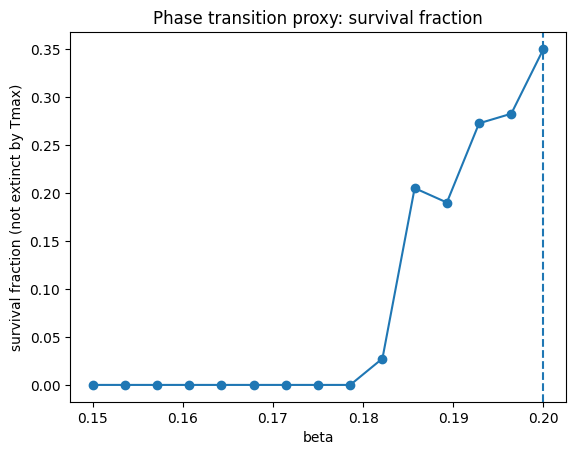

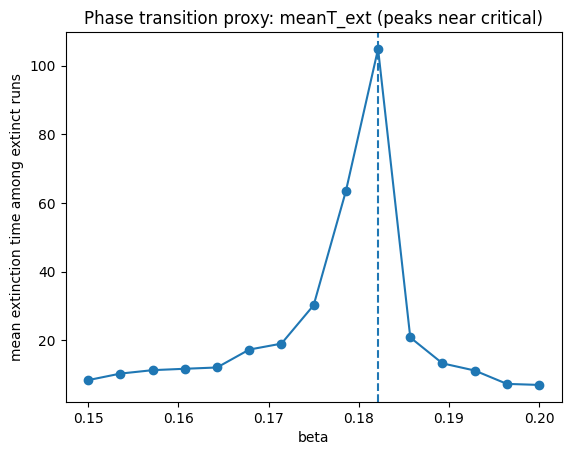

In [75]:
import numpy as np
import matplotlib.pyplot as plt

def sweep_beta(L=64, mu=0.5, betas=None, n_trials=400, Tmax=5000, n_seed=5, seed0=0):
    if betas is None:
        betas = np.linspace(0.02, 0.30, 15)  # broad first pass

    betas = np.asarray(betas, float)
    surv = np.zeros_like(betas)
    meanT_ext = np.zeros_like(betas)
    meanS_ext = np.zeros_like(betas)

    for bi, beta in enumerate(betas):
        Ss = np.empty(n_trials, float)
        Ts = np.empty(n_trials, float)
        ext = np.empty(n_trials, bool)

        for r in range(n_trials):
            S, T, extinct = avalanche_trial(
                L=L, beta=float(beta), mu=float(mu),
                Tmax=Tmax, n_seed=n_seed,
                seed=seed0 + 100000*bi + r
            )
            Ss[r] = S; Ts[r] = T; ext[r] = extinct

        surv[bi] = 1.0 - ext.mean()
        meanT_ext[bi] = Ts[ext].mean() if ext.any() else np.nan
        meanS_ext[bi] = Ss[ext].mean() if ext.any() else np.nan

        print(f"beta={beta:.4f}  survFrac={surv[bi]:.3f}  meanT_ext={meanT_ext[bi]:.1f}")

    summary = {"beta": betas, "survival_fraction": surv, "meanT_ext": meanT_ext, "meanS_ext": meanS_ext}
    return summary

# ---- run a coarse sweep ----
L = 64
Tmax = 5000
mu = 0.5
n_seed = 1
n_trials = 400

betas = np.linspace(0.15, 0.20, 15)
summary = sweep_beta(L=L, mu=mu, betas=betas, n_trials=n_trials, Tmax=Tmax, n_seed=n_seed, seed0=1)

beta = summary["beta"]
surv = summary["survival_fraction"]
meanT_ext = summary["meanT_ext"]

# crude estimates:
beta_surv50 = float(beta[np.argmin(np.abs(surv - 0.5))])            # where survival crosses ~0.5
beta_peakT  = float(beta[np.nanargmax(meanT_ext)])                  # peak mean extinction time

print("\nCrude beta_c region:")
print("  survival ~0.5 at beta =", beta_surv50)
print("  peak meanT_ext at beta =", beta_peakT)

# plots
plt.figure()
plt.plot(beta, surv, marker="o")
plt.axvline(beta_surv50, linestyle="--")
plt.xlabel("beta"); plt.ylabel("survival fraction (not extinct by Tmax)")
plt.title("Phase transition proxy: survival fraction")
plt.show()

plt.figure()
plt.plot(beta, meanT_ext, marker="o")
plt.axvline(beta_peakT, linestyle="--")
plt.xlabel("beta"); plt.ylabel("mean extinction time among extinct runs")
plt.title("Phase transition proxy: meanT_ext (peaks near critical)")
plt.show()


[below] beta=0.1714  survFrac=0.000  meanT_ext=22.1  n_ext=800/800
[crit] beta=0.1821  survFrac=0.016  meanT_ext=163.2  n_ext=787/800
[above] beta=0.1857  survFrac=0.134  meanT_ext=19.7  n_ext=693/800


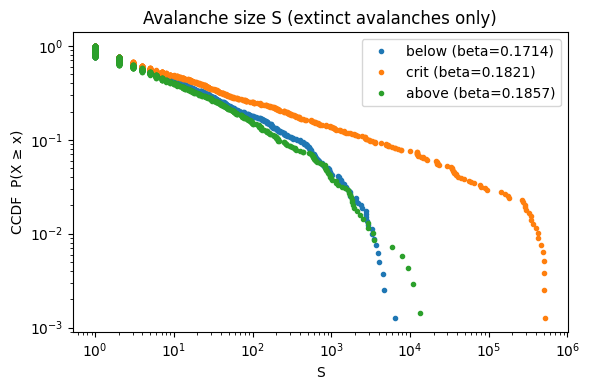

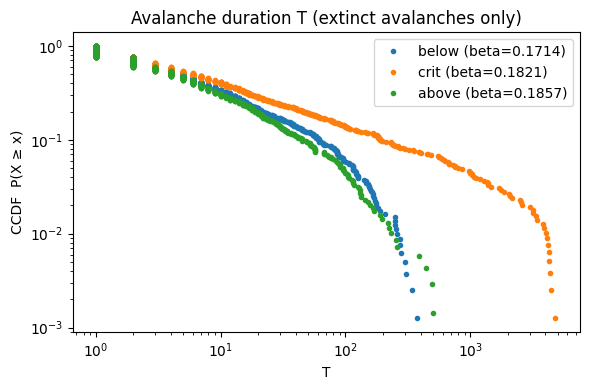

[below] beta=0.1714  sigma_hat≈0.938  (from 6 example traces)
[crit] beta=0.1821  sigma_hat≈0.996  (from 6 example traces)
[above] beta=0.1857  sigma_hat≈0.913  (from 6 example traces)
[QS] below beta=0.1714  tau_int≈5.5  (samples=5500)
[QS] crit beta=0.1821  tau_int≈66.3  (samples=5500)
[QS] above beta=0.1857  tau_int≈26.6  (samples=5500)


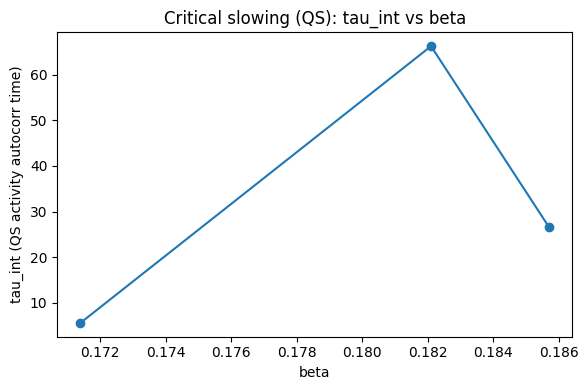

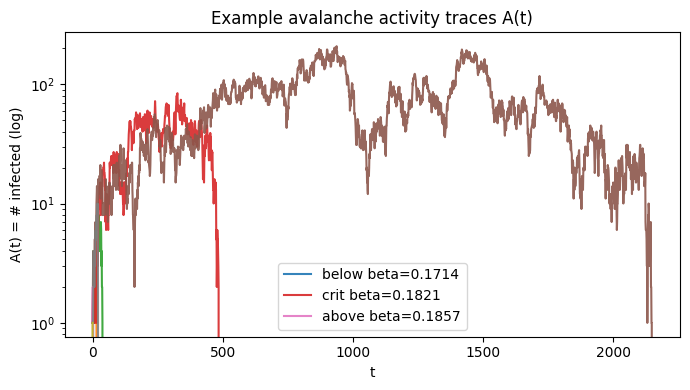

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Helpers: avalanche trial WITH activity trace
# ------------------------------------------------------------
def avalanche_trial_trace(L, beta, mu, Tmax=5000, n_seed=1, seed=0, return_X_snaps=False, snap_times=(0,10,50,200,1000)):
    rng = np.random.default_rng(seed)
    X = np.zeros((L, L), dtype=np.int8)

    # seed infections
    for _ in range(n_seed):
        i, j = rng.integers(0, L), rng.integers(0, L)
        X[i, j] = 1

    A_trace = []
    snaps = {}

    for t in range(Tmax):
        A = int(X.sum())
        A_trace.append(A)

        if return_X_snaps and (t in snap_times):
            snaps[t] = X.copy()

        if A == 0:
            # extinct at time t (A_trace includes A=0 at extinction time)
            S = int(np.sum(A_trace))           # includes final zero (doesn't matter)
            T = t                              # extinction time index
            return S, T, True, np.array(A_trace, dtype=int), snaps

        X = sis_step(X, beta, mu, rng)

    # survived to Tmax (censored)
    S = int(np.sum(A_trace))
    return S, Tmax, False, np.array(A_trace, dtype=int), snaps


def run_avalanches(L, beta, mu, n_trials=500, Tmax=5000, n_seed=1, seed0=0, n_example=5, want_snaps=False):
    Ss = np.empty(n_trials, float)
    Ts = np.empty(n_trials, float)
    ext = np.empty(n_trials, bool)
    traces = []
    snaps_list = []

    for r in range(n_trials):
        S, T, extinct, A_trace, snaps = avalanche_trial_trace(
            L=L, beta=float(beta), mu=float(mu), Tmax=Tmax,
            n_seed=n_seed, seed=seed0 + r,
            return_X_snaps=want_snaps
        )
        Ss[r] = S
        Ts[r] = T
        ext[r] = extinct

        # keep a few example traces for plotting
        if len(traces) < n_example:
            traces.append(A_trace)
            if want_snaps:
                snaps_list.append(snaps)

    return Ss, Ts, ext, traces, snaps_list


# ------------------------------------------------------------
# Avalanche distributions: CCDF on log-log
# ------------------------------------------------------------
def ccdf(x):
    x = np.asarray(x, float)
    x = x[np.isfinite(x) & (x > 0)]
    if x.size == 0:
        return np.array([]), np.array([])
    xs = np.sort(x)
    cc = 1.0 - (np.arange(1, xs.size + 1) / xs.size)
    return xs, cc

def plot_ccdfs(dists, title, xlabel):
    plt.figure(figsize=(6,4))
    for label, vals in dists.items():
        xs, cc = ccdf(vals)
        if xs.size:
            plt.loglog(xs, cc, marker=".", linestyle="none", label=label)
    plt.xlabel(xlabel); plt.ylabel("CCDF  P(X ≥ x)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# Branching ratio (effective sigma) from activity time series
# ------------------------------------------------------------
def branching_sigma_from_traces(traces, drop_zeros=True):
    """
    Estimate an effective branching ratio sigma from A(t) traces.
    Simple estimator: slope of regression through origin for A(t+1) vs A(t):
        sigma = sum A_t A_{t+1} / sum A_t^2
    pooled over all traces (excluding last point).
    """
    num = 0.0
    den = 0.0
    for A in traces:
        A = np.asarray(A, float)
        if A.size < 2:
            continue
        At = A[:-1]
        At1 = A[1:]
        if drop_zeros:
            m = At > 0
            At = At[m]; At1 = At1[m]
        num += np.sum(At * At1)
        den += np.sum(At * At)
    return np.nan if den == 0 else (num / den)


# ------------------------------------------------------------
# Critical slowing: Quasi-stationary (QS) simulation + tau_int
# ------------------------------------------------------------
def autocorr_fft(x):
    """Unbiased-ish autocorrelation using FFT; returns acf normalized so acf[0]=1."""
    x = np.asarray(x, float)
    x = x - x.mean()
    n = len(x)
    if n < 2:
        return np.array([1.0])
    f = np.fft.rfft(x, n=2*n)
    ac = np.fft.irfft(f * np.conjugate(f))[:n]
    ac /= ac[0] if ac[0] != 0 else 1.0
    return ac

def tau_int_from_acf(acf, max_lag=None):
    """
    Integrated autocorrelation time:
      tau_int = 1 + 2 * sum_{lag=1..L} acf[lag]
    where L is chosen until acf first goes negative (or max_lag).
    """
    if max_lag is None:
        # stop at first negative (common simple rule)
        neg = np.where(acf[1:] < 0)[0]
        L = int(neg[0] + 1) if neg.size else len(acf) - 1
    else:
        L = min(int(max_lag), len(acf) - 1)
    return 1.0 + 2.0 * np.sum(acf[1:L+1])

def qs_run_activity(L, beta, mu, T=60000, burn=5000, buffer_size=200, save_every=10, seed=0):
    """
    Quasi-stationary SIS:
    - run SIS
    - maintain a buffer of previously-seen active states
    - if extinction occurs, replace state with a random buffer state
    Returns activity series A(t) after burn-in, sampled every 'save_every' steps.
    """
    rng = np.random.default_rng(seed)
    X = (rng.random((L,L)) < 0.1).astype(np.int8)  # small initial density

    # buffer of active states
    buffer = []
    A_series = []

    for t in range(T):
        A = int(X.sum())
        if A == 0:
            # resurrect from buffer (QS trick)
            if buffer:
                X = buffer[rng.integers(0, len(buffer))].copy()
            else:
                # if buffer empty, re-seed lightly
                X = (rng.random((L,L)) < 0.05).astype(np.int8)
        else:
            # occasionally store an active state
            if (t % 20 == 0) and (len(buffer) < buffer_size):
                buffer.append(X.copy())
            elif (t % 20 == 0) and buffer_size > 0:
                # overwrite random buffer entry
                buffer[rng.integers(0, buffer_size)] = X.copy()

        # step dynamics
        X = sis_step(X, beta, mu, rng)

        # record activity after burn-in
        if t >= burn and (t % save_every == 0):
            A_series.append(int(X.sum()))

    return np.array(A_series, dtype=float)


# ------------------------------------------------------------
# RUN: choose below / near / above
# ------------------------------------------------------------
L = 64
Tmax = 5000
mu = 0.5
n_seed = 1          # recommended for clean avalanche definition
n_trials = 800      # increase for smoother tails
n_example = 6

beta_below = 0.1714
beta_crit  = 0.1821  # where meanT_ext peaked
beta_above = 0.1857  # where survival jumps

betas = [("below", beta_below), ("crit", beta_crit), ("above", beta_above)]

results = {}
for name, b in betas:
    Ss, Ts, ext, traces, snaps = run_avalanches(
        L=L, beta=b, mu=mu, n_trials=n_trials, Tmax=Tmax,
        n_seed=n_seed, seed0=1000 + int(1e6*b), n_example=n_example,
        want_snaps=False
    )
    results[name] = dict(beta=b, S=Ss, T=Ts, extinct=ext, traces=traces)
    print(f"[{name}] beta={b:.4f}  survFrac={1-ext.mean():.3f}  meanT_ext={Ts[ext].mean():.1f}  n_ext={ext.sum()}/{n_trials}")

# 1) Avalanche distributions (use extinct only to avoid censoring artefacts)
plot_ccdfs(
    {f"{k} (beta={v['beta']:.4f})": v["S"][v["extinct"]] for k,v in results.items()},
    title="Avalanche size S (extinct avalanches only)",
    xlabel="S"
)
plot_ccdfs(
    {f"{k} (beta={v['beta']:.4f})": v["T"][v["extinct"]] for k,v in results.items()},
    title="Avalanche duration T (extinct avalanches only)",
    xlabel="T"
)

# 2) Branching ratio sigma from activity traces
#    (use the example traces you stored; for better estimates, store more traces or compute inside run_avalanches)
for name, v in results.items():
    sig = branching_sigma_from_traces(v["traces"])
    print(f"[{name}] beta={v['beta']:.4f}  sigma_hat≈{sig:.3f}  (from {len(v['traces'])} example traces)")

# 3) Critical slowing: QS autocorrelation time of activity
taus = {}
for name, b in betas:
    A = qs_run_activity(L=L, beta=b, mu=mu, T=60000, burn=5000, buffer_size=200, save_every=10, seed=42 + int(1e6*b))
    acf = autocorr_fft(A)
    tau = tau_int_from_acf(acf)
    taus[name] = (b, tau)
    print(f"[QS] {name} beta={b:.4f}  tau_int≈{tau:.1f}  (samples={len(A)})")

plt.figure(figsize=(6,4))
plt.plot([taus[k][0] for k in taus], [taus[k][1] for k in taus], marker="o")
plt.xlabel("beta"); plt.ylabel("tau_int (QS activity autocorr time)")
plt.title("Critical slowing (QS): tau_int vs beta")
plt.tight_layout()
plt.show()

# 4) Example avalanche trajectories A(t)
plt.figure(figsize=(7,4))
for name, v in results.items():
    for i, tr in enumerate(v["traces"][:3]):  # plot first 3 from each
        plt.plot(tr, alpha=0.9, label=f"{name} beta={v['beta']:.4f}" if i==0 else None)
plt.yscale("log")
plt.xlabel("t"); plt.ylabel("A(t) = # infected (log)")
plt.title("Example avalanche activity traces A(t)")
plt.legend()
plt.tight_layout()
plt.show()


beta=0.1720  tau_int=8.16 ± 2.53   (reps=3, samples=1800)
beta=0.1730  tau_int=15.87 ± 4.35   (reps=3, samples=1800)
beta=0.1740  tau_int=14.85 ± 8.55   (reps=3, samples=1800)
beta=0.1750  tau_int=11.97 ± 1.52   (reps=3, samples=1800)
beta=0.1760  tau_int=23.74 ± 21.61   (reps=3, samples=1800)
beta=0.1770  tau_int=18.48 ± 6.88   (reps=3, samples=1800)
beta=0.1780  tau_int=16.32 ± 6.40   (reps=3, samples=1800)
beta=0.1790  tau_int=32.32 ± 16.49   (reps=3, samples=1800)
beta=0.1800  tau_int=48.73 ± 22.27   (reps=3, samples=1800)
beta=0.1810  tau_int=70.28 ± 24.36   (reps=3, samples=1800)
beta=0.1820  tau_int=50.51 ± 8.11   (reps=3, samples=1800)
beta=0.1830  tau_int=67.41 ± 20.40   (reps=3, samples=1800)
beta=0.1840  tau_int=36.99 ± 14.54   (reps=3, samples=1800)
beta=0.1850  tau_int=43.03 ± 11.14   (reps=3, samples=1800)
beta=0.1860  tau_int=36.26 ± 8.60   (reps=3, samples=1800)


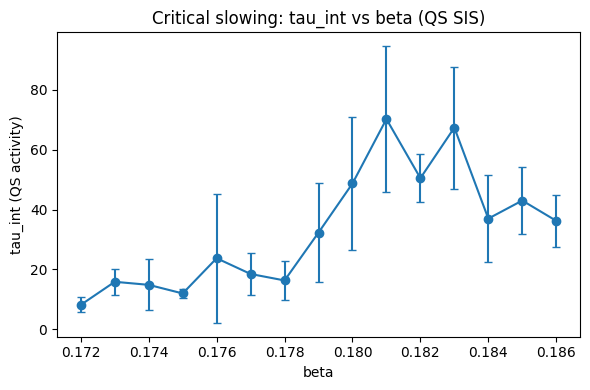

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- QS SIS simulation (activity only) ----------
def qs_activity_series(sis_step, L, beta, mu, T=20000, burn=2000,
                      buffer_size=100, save_every=10, seed=0):
    """
    Quasi-stationary SIS on LxL lattice:
    - maintain buffer of previously seen active states
    - if extinction occurs, resurrect from buffer
    Returns A(t) after burn-in, sampled every 'save_every' steps.
    """
    rng = np.random.default_rng(seed)
    X = (rng.random((L, L)) < 0.05).astype(np.int8)  # small starting density

    buffer = []
    A = []

    for t in range(T):
        if X.sum() == 0:
            # resurrect (QS)
            if buffer:
                X = buffer[rng.integers(0, len(buffer))].copy()
            else:
                X = (rng.random((L, L)) < 0.05).astype(np.int8)

        # occasionally store active configs
        if (t % 20 == 0) and (X.sum() > 0):
            if len(buffer) < buffer_size:
                buffer.append(X.copy())
            else:
                buffer[rng.integers(0, buffer_size)] = X.copy()

        # step
        X = sis_step(X, beta, mu, rng)

        # record
        if t >= burn and (t % save_every == 0):
            A.append(float(X.sum()))

    return np.array(A, dtype=float)

# ---------- Autocorrelation + tau_int ----------
def autocorr_fft(x):
    x = np.asarray(x, float)
    x = x - x.mean()
    n = len(x)
    if n < 2:
        return np.array([1.0])
    f = np.fft.rfft(x, n=2*n)
    ac = np.fft.irfft(f * np.conjugate(f))[:n]
    ac /= ac[0] if ac[0] != 0 else 1.0
    return ac

def tau_int(acf, max_lag=800):
    """
    Integrated autocorr time with a practical cutoff:
    sum until first negative OR max_lag.
    """
    L = min(max_lag, len(acf) - 1)
    neg = np.where(acf[1:L+1] < 0)[0]
    if neg.size:
        L = int(neg[0] + 1)
    return 1.0 + 2.0 * np.sum(acf[1:L+1])

# ---------- Sweep beta ----------
def sweep_tau_int(sis_step, betas, L=64, mu=0.5, reps=3,
                  T=20000, burn=2000, buffer_size=100, save_every=10,
                  max_lag=800, seed0=0):
    betas = np.asarray(betas, float)
    taus_mean = np.zeros_like(betas)
    taus_std  = np.zeros_like(betas)

    for i, b in enumerate(betas):
        taus = []
        for r in range(reps):
            A = qs_activity_series(
                sis_step, L=L, beta=float(b), mu=float(mu),
                T=T, burn=burn, buffer_size=buffer_size, save_every=save_every,
                seed=seed0 + 10000*i + r
            )
            acf = autocorr_fft(A)
            taus.append(tau_int(acf, max_lag=max_lag))
        taus = np.array(taus, float)
        taus_mean[i] = taus.mean()
        taus_std[i]  = taus.std(ddof=1) if reps > 1 else 0.0
        print(f"beta={b:.4f}  tau_int={taus_mean[i]:.2f} ± {taus_std[i]:.2f}   (reps={reps}, samples={len(A)})")

    return taus_mean, taus_std

# ----------------- YOUR SETTINGS -----------------
# Use your existing sis_step (already defined in your notebook)
L = 64
mu = 0.5

betas = np.linspace(0.172, 0.186, 15)  # dense, quick
taus_mean, taus_std = sweep_tau_int(
    sis_step, betas, L=L, mu=mu,
    reps=3,              # quick; bump to 5 for smoother errorbars
    T=20000, burn=2000,  # quick but decent
    buffer_size=100,
    save_every=10,       # fewer points -> faster FFTs
    max_lag=800
)

plt.figure(figsize=(6,4))
plt.errorbar(betas, taus_mean, yerr=taus_std, marker="o", linestyle="-", capsize=3)
plt.xlabel("beta")
plt.ylabel("tau_int (QS activity)")
plt.title("Critical slowing: tau_int vs beta (QS SIS)")
plt.tight_layout()
plt.show()


beta=0.1720  survFrac=0.000  medT_ext=3.5  medS_ext=4.0  sigma=0.968
beta=0.1730  survFrac=0.000  medT_ext=4.5  medS_ext=6.0  sigma=0.980
beta=0.1740  survFrac=0.000  medT_ext=6.0  medS_ext=7.0  sigma=0.984
beta=0.1750  survFrac=0.000  medT_ext=5.0  medS_ext=6.5  sigma=0.979
beta=0.1760  survFrac=0.000  medT_ext=4.0  medS_ext=6.0  sigma=0.984
beta=0.1770  survFrac=0.000  medT_ext=4.0  medS_ext=5.0  sigma=0.988
beta=0.1780  survFrac=0.000  medT_ext=5.5  medS_ext=8.0  sigma=0.987
beta=0.1790  survFrac=0.000  medT_ext=4.0  medS_ext=6.0  sigma=0.991
beta=0.1800  survFrac=0.004  medT_ext=6.0  medS_ext=8.0  sigma=0.995
beta=0.1810  survFrac=0.004  medT_ext=4.0  medS_ext=7.0  sigma=0.996
beta=0.1820  survFrac=0.020  medT_ext=6.0  medS_ext=10.0  sigma=0.997
beta=0.1830  survFrac=0.068  medT_ext=4.0  medS_ext=5.0  sigma=0.998
beta=0.1840  survFrac=0.108  medT_ext=4.0  medS_ext=6.0  sigma=0.999
beta=0.1850  survFrac=0.128  medT_ext=4.0  medS_ext=5.0  sigma=0.999
beta=0.1860  survFrac=0.152  medT

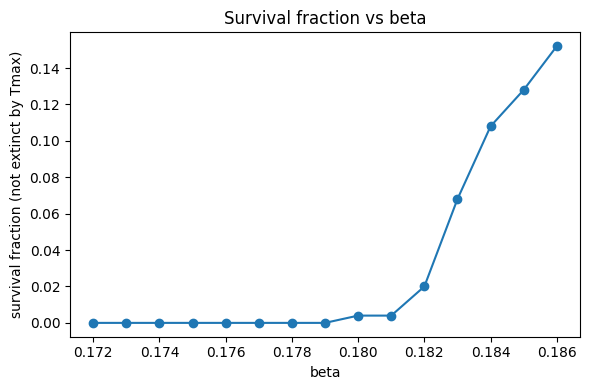

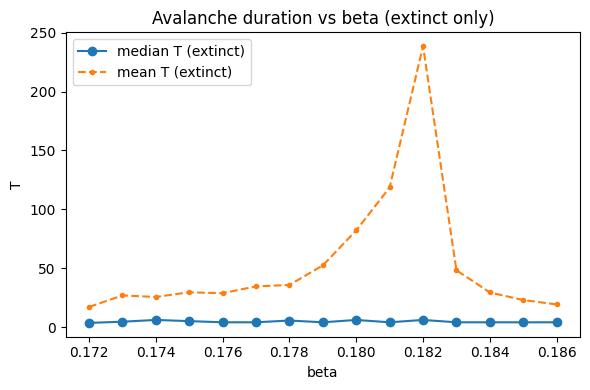

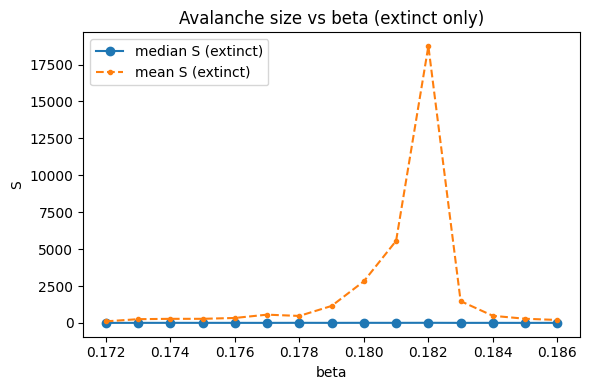

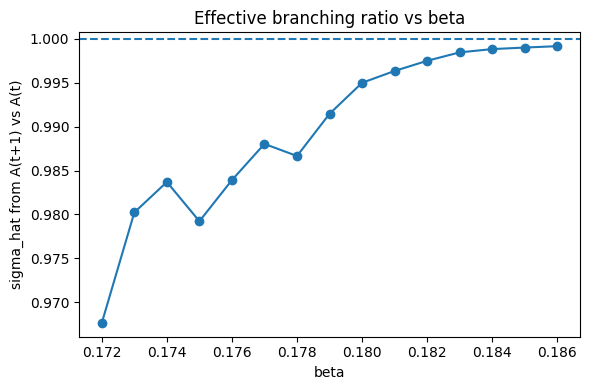

Using nearest betas from sweep grid: below=0.175000, crit=0.182000, above=0.186000


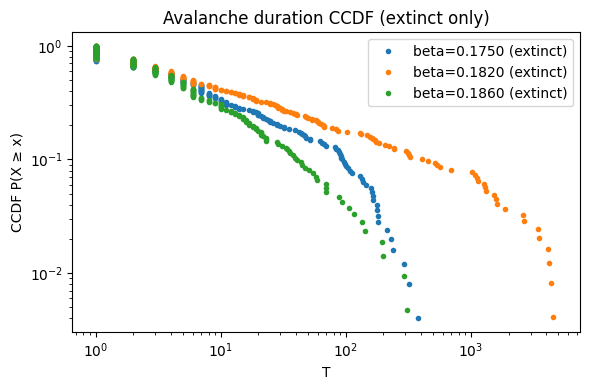

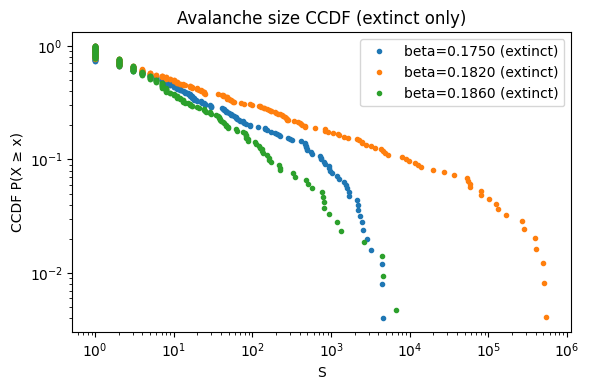

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# One avalanche trial: seed -> extinction (or censor at Tmax)
# Also accumulates branching estimator terms from A(t)
# ------------------------------------------------------------
def avalanche_trial_stats(L, beta, mu, Tmax=5000, n_seed=1, seed=0):
    rng = np.random.default_rng(seed)
    X = np.zeros((L, L), dtype=np.int8)

    # seed infections
    for _ in range(n_seed):
        i, j = rng.integers(0, L), rng.integers(0, L)
        X[i, j] = 1

    S = 0.0
    T = 0
    num = 0.0  # sum A_t * A_{t+1}
    den = 0.0  # sum A_t^2

    for _ in range(Tmax):
        A = float(X.sum())
        if A == 0:
            return S, T, True, num, den  # should be rare with n_seed>=1

        S += A

        Xn = sis_step(X, beta, mu, rng)
        A1 = float(Xn.sum())

        num += A * A1
        den += A * A

        T += 1
        X = Xn

        if A1 == 0:
            return S, T, True, num, den  # extinct after this step

    return S, Tmax, False, num, den


# ------------------------------------------------------------
# Sweep beta: collect S,T distributions + sigma_hat
# ------------------------------------------------------------
def sweep_avalanches_and_sigma(betas, L=64, mu=0.5, Tmax=5000, n_seed=1,
                              n_trials=250, seed0=0, verbose=True):
    betas = np.asarray(betas, float)

    survFrac = np.zeros_like(betas)
    medT_ext = np.full_like(betas, np.nan)
    medS_ext = np.full_like(betas, np.nan)
    meanT_ext = np.full_like(betas, np.nan)
    meanS_ext = np.full_like(betas, np.nan)
    sigma_hat = np.full_like(betas, np.nan)

    dists = {}

    for i, b in enumerate(betas):
        Ss = np.empty(n_trials, float)
        Ts = np.empty(n_trials, float)
        ext = np.empty(n_trials, bool)

        num = 0.0
        den = 0.0

        for r in range(n_trials):
            S, T, extinct, n, d = avalanche_trial_stats(
                L=L, beta=float(b), mu=float(mu),
                Tmax=Tmax, n_seed=n_seed,
                seed=seed0 + 100000*i + r
            )
            Ss[r] = S
            Ts[r] = T
            ext[r] = extinct
            num += n
            den += d

        survFrac[i] = 1.0 - ext.mean()

        if ext.any():
            Te = Ts[ext]
            Se = Ss[ext]
            medT_ext[i] = np.median(Te)
            medS_ext[i] = np.median(Se)
            meanT_ext[i] = Te.mean()
            meanS_ext[i] = Se.mean()

        sigma_hat[i] = (num / den) if den > 0 else np.nan

        # store using the EXACT float value used in betas
        dists[float(b)] = (Ss, Ts, ext)

        if verbose:
            print(f"beta={b:.4f}  survFrac={survFrac[i]:.3f}  "
                  f"medT_ext={medT_ext[i]:.1f}  medS_ext={medS_ext[i]:.1f}  sigma={sigma_hat[i]:.3f}")

    summary = dict(
        beta=betas,
        survFrac=survFrac,
        medT_ext=medT_ext,
        medS_ext=medS_ext,
        meanT_ext=meanT_ext,
        meanS_ext=meanS_ext,
        sigma=sigma_hat
    )
    return summary, dists


# ------------------------------------------------------------
# CCDF plot helper (for size/duration distributions)
# ------------------------------------------------------------
def ccdf(x):
    x = np.asarray(x, float)
    x = x[np.isfinite(x) & (x > 0)]
    if x.size == 0:
        return np.array([]), np.array([])
    xs = np.sort(x)
    cc = 1.0 - (np.arange(1, xs.size + 1) / xs.size)
    return xs, cc

def plot_ccdf_three(dists, betas_pick, which="T", title=""):
    plt.figure(figsize=(6,4))
    for b in betas_pick:
        S, T, ext = dists[float(b)]
        vals = (T if which == "T" else S)[ext]  # extinct only to avoid censoring artefacts
        xs, cc = ccdf(vals)
        if xs.size:
            plt.loglog(xs, cc, marker=".", linestyle="none", label=f"beta={b:.4f} (extinct)")
    plt.xlabel(which); plt.ylabel("CCDF P(X ≥ x)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# FIX 1: choose nearest available beta from the sweep grid
# ------------------------------------------------------------
def nearest_beta(dists, b_target):
    keys = np.array(sorted(dists.keys()), dtype=float)
    return float(keys[np.argmin(np.abs(keys - b_target))])


# =========================
# RUN (quick but informative)
# =========================
L = 64
mu = 0.5
Tmax = 5000
n_seed = 1

betas = np.linspace(0.172, 0.186, 15)

summary, dists = sweep_avalanches_and_sigma(
    betas, L=L, mu=mu, Tmax=Tmax, n_seed=n_seed,
    n_trials=250, seed0=1, verbose=True
)

# --- curves vs beta ---
b = summary["beta"]

plt.figure(figsize=(6,4))
plt.plot(b, summary["survFrac"], marker="o")
plt.xlabel("beta"); plt.ylabel("survival fraction (not extinct by Tmax)")
plt.title("Survival fraction vs beta")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(b, summary["medT_ext"], marker="o", label="median T (extinct)")
plt.plot(b, summary["meanT_ext"], marker=".", linestyle="--", label="mean T (extinct)")
plt.xlabel("beta"); plt.ylabel("T")
plt.title("Avalanche duration vs beta (extinct only)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(b, summary["medS_ext"], marker="o", label="median S (extinct)")
plt.plot(b, summary["meanS_ext"], marker=".", linestyle="--", label="mean S (extinct)")
plt.xlabel("beta"); plt.ylabel("S")
plt.title("Avalanche size vs beta (extinct only)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(b, summary["sigma"], marker="o")
plt.axhline(1.0, linestyle="--")
plt.xlabel("beta"); plt.ylabel("sigma_hat from A(t+1) vs A(t)")
plt.title("Effective branching ratio vs beta")
plt.tight_layout(); plt.show()

# --- distributions below / near / above (map targets to actual betas in dists) ---
beta_below = nearest_beta(dists, 0.1750)
beta_crit  = nearest_beta(dists, 0.1821)
beta_above = nearest_beta(dists, 0.1857)

print("Using nearest betas from sweep grid:",
      f"below={beta_below:.6f}, crit={beta_crit:.6f}, above={beta_above:.6f}")

plot_ccdf_three(dists, [beta_below, beta_crit, beta_above], which="T",
                title="Avalanche duration CCDF (extinct only)")
plot_ccdf_three(dists, [beta_below, beta_crit, beta_above], which="S",
                title="Avalanche size CCDF (extinct only)")


beta=0.1720  tau_int=15.03  cosDist=0.8798  dA=7.05  ham=28.4
beta=0.1730  tau_int=10.27  cosDist=0.8756  dA=6.85  ham=29.4
beta=0.1740  tau_int=34.96  cosDist=0.8720  dA=8.13  ham=38.7
beta=0.1750  tau_int=13.35  cosDist=0.8694  dA=8.25  ham=40.1
beta=0.1760  tau_int=11.56  cosDist=0.8673  dA=8.03  ham=39.4
beta=0.1770  tau_int=24.09  cosDist=0.8611  dA=8.73  ham=50.8
beta=0.1780  tau_int=26.86  cosDist=0.8604  dA=9.37  ham=56.3
beta=0.1790  tau_int=33.26  cosDist=0.8562  dA=10.16  ham=70.8
beta=0.1800  tau_int=31.21  cosDist=0.8501  dA=12.28  ham=102.5
beta=0.1810  tau_int=55.00  cosDist=0.8453  dA=14.39  ham=147.0
beta=0.1820  tau_int=60.87  cosDist=0.8401  dA=16.23  ham=191.2
beta=0.1830  tau_int=83.06  cosDist=0.8359  dA=20.45  ham=304.9
beta=0.1840  tau_int=44.94  cosDist=0.8294  dA=24.41  ham=425.7
beta=0.1850  tau_int=37.98  cosDist=0.8256  dA=26.98  ham=516.0
beta=0.1860  tau_int=21.83  cosDist=0.8203  dA=29.54  ham=613.9


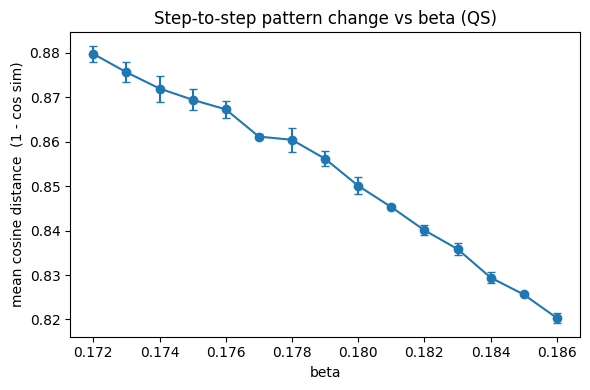

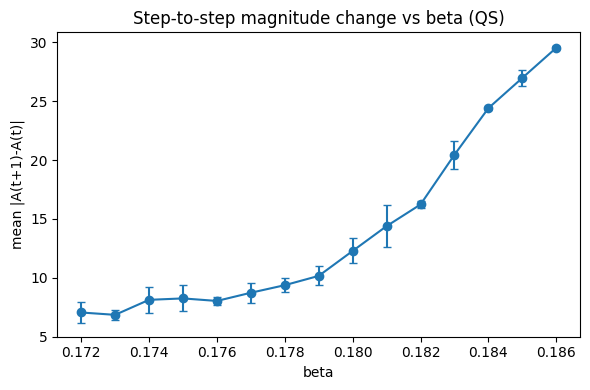

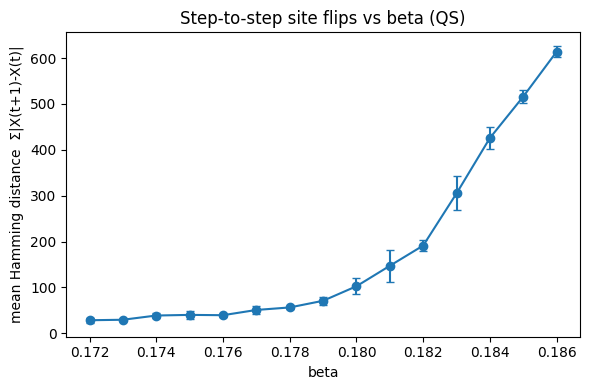

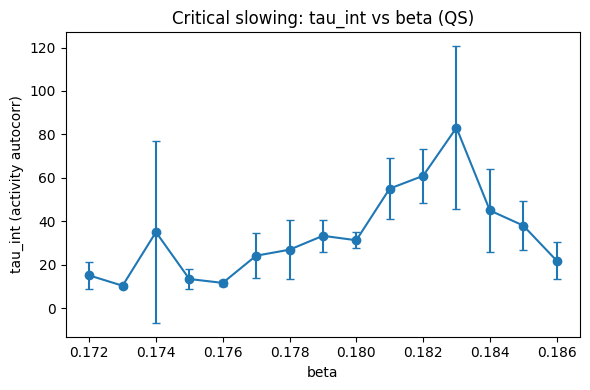

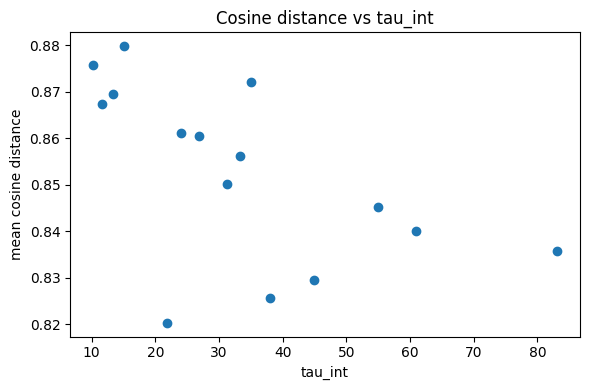

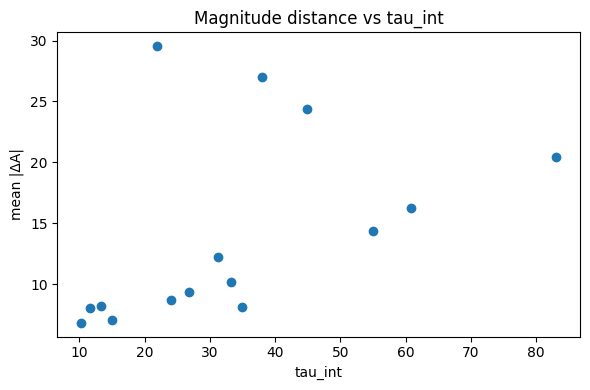

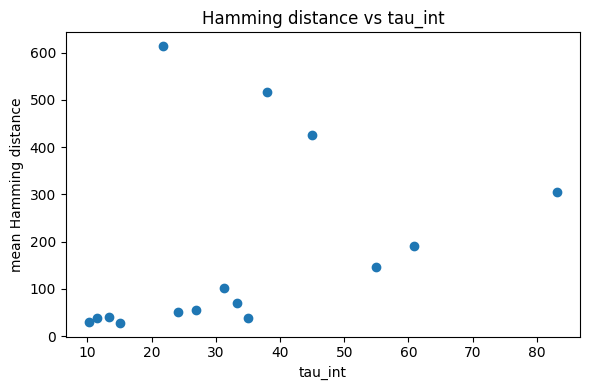

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# QS run that records:
#  - activity A(t)=sum X
#  - cosine distance between X(t) and X(t+1)   (pattern/orientation change)
#  - magnitude difference between A(t) and A(t+1) (scale change)
#  - Hamming / L1 distance sum|X(t)-X(t+1)|     (number of spin flips)
# and then tau_int from autocorr of A(t)
# ============================================================

def autocorr_fft(x):
    x = np.asarray(x, float)
    x = x - x.mean()
    n = len(x)
    if n < 2:
        return np.array([1.0])
    f = np.fft.rfft(x, n=2*n)
    ac = np.fft.irfft(f * np.conjugate(f))[:n]
    ac /= ac[0] if ac[0] != 0 else 1.0
    return ac

def tau_int_from_acf(acf, max_lag=800):
    L = min(max_lag, len(acf) - 1)
    neg = np.where(acf[1:L+1] < 0)[0]
    if neg.size:
        L = int(neg[0] + 1)
    return 1.0 + 2.0 * np.sum(acf[1:L+1])

def qs_metrics_series(
    L, beta, mu,
    T=20000, burn=2000,
    buffer_size=100,
    save_every=10,
    seed=0,
):
    """
    Quasi-stationary SIS:
      - resurrect from buffer if extinction occurs
      - record metrics every 'save_every' steps after burn-in
    Returns:
      A (N,), cosdist (N-1,), dA (N-1,), hamming (N-1,)
    """
    rng = np.random.default_rng(seed)
    X = (rng.random((L, L)) < 0.05).astype(np.int8)

    buffer = []
    A_list = []
    cos_list = []
    dA_list = []
    ham_list = []

    X_prev = None
    A_prev = None

    for t in range(T):
        # QS resurrection if extinct
        if X.sum() == 0:
            if buffer:
                X = buffer[rng.integers(0, len(buffer))].copy()
            else:
                X = (rng.random((L, L)) < 0.05).astype(np.int8)

        # store active configs occasionally
        if (t % 20 == 0) and (X.sum() > 0):
            if len(buffer) < buffer_size:
                buffer.append(X.copy())
            else:
                buffer[rng.integers(0, buffer_size)] = X.copy()

        # step SIS
        X = sis_step(X, beta, mu, rng)

        # record after burn-in
        if t >= burn and (t % save_every == 0):
            A = int(X.sum())
            A_list.append(A)

            if X_prev is not None:
                # Flatten only when needed (4096 elems for L=64; fine)
                x = X_prev.ravel().astype(np.float32)
                y = X.ravel().astype(np.float32)

                # cosine distance: 1 - (x·y)/(||x|| ||y||)
                # For binary x,y: x·y is overlap count; ||x|| = sqrt(A_prev), ||y|| = sqrt(A)
                dot = float(np.dot(x, y))
                nx = float(np.sqrt(A_prev))
                ny = float(np.sqrt(A))
                if nx > 0 and ny > 0:
                    cos_sim = dot / (nx * ny)
                    cos_dist = 1.0 - cos_sim
                else:
                    cos_dist = np.nan  # shouldn't happen in QS but keep safe

                # magnitude distance in activity (scale change)
                dA = abs(A - A_prev)

                # summed difference (Hamming / L1): how many sites changed state
                ham = float(np.sum(np.abs(y - x)))

                cos_list.append(cos_dist)
                dA_list.append(dA)
                ham_list.append(ham)

            X_prev = X.copy()
            A_prev = A

    A_arr = np.array(A_list, dtype=float)
    cos_arr = np.array(cos_list, dtype=float)
    dA_arr  = np.array(dA_list, dtype=float)
    ham_arr = np.array(ham_list, dtype=float)

    return A_arr, cos_arr, dA_arr, ham_arr

def sweep_beta_metrics(
    betas, L=64, mu=0.5,
    reps=3,
    T=20000, burn=2000, buffer_size=100, save_every=10,
    max_lag=800,
    seed0=0,
):
    betas = np.asarray(betas, float)

    out = {
        "beta": betas,
        "tau_int_mean": np.zeros_like(betas),
        "tau_int_std":  np.zeros_like(betas),
        "cos_mean":     np.zeros_like(betas),
        "cos_std":      np.zeros_like(betas),
        "dA_mean":      np.zeros_like(betas),
        "dA_std":       np.zeros_like(betas),
        "ham_mean":     np.zeros_like(betas),
        "ham_std":      np.zeros_like(betas),
    }

    for i, b in enumerate(betas):
        taus = []
        coss = []
        dAs  = []
        hams = []

        for r in range(reps):
            A, cosd, dA, ham = qs_metrics_series(
                L=L, beta=float(b), mu=float(mu),
                T=T, burn=burn, buffer_size=buffer_size, save_every=save_every,
                seed=seed0 + 10000*i + r
            )

            acf = autocorr_fft(A)
            tau = tau_int_from_acf(acf, max_lag=max_lag)

            # time-averaged step-to-step metrics
            taus.append(tau)
            coss.append(np.nanmean(cosd))
            dAs.append(np.nanmean(dA))
            hams.append(np.nanmean(ham))

        taus = np.array(taus, float)
        coss = np.array(coss, float)
        dAs  = np.array(dAs, float)
        hams = np.array(hams, float)

        out["tau_int_mean"][i] = taus.mean()
        out["tau_int_std"][i]  = taus.std(ddof=1) if reps > 1 else 0.0
        out["cos_mean"][i]     = coss.mean()
        out["cos_std"][i]      = coss.std(ddof=1) if reps > 1 else 0.0
        out["dA_mean"][i]      = dAs.mean()
        out["dA_std"][i]       = dAs.std(ddof=1) if reps > 1 else 0.0
        out["ham_mean"][i]     = hams.mean()
        out["ham_std"][i]      = hams.std(ddof=1) if reps > 1 else 0.0

        print(f"beta={b:.4f}  tau_int={out['tau_int_mean'][i]:.2f}  "
              f"cosDist={out['cos_mean'][i]:.4f}  dA={out['dA_mean'][i]:.2f}  ham={out['ham_mean'][i]:.1f}")

    return out


# =========================
# RUN (your settings)
# =========================
L = 64
mu = 0.5
betas = np.linspace(0.172, 0.186, 15)

# "Quick but smooth-ish" defaults:
#   reps=2 is fastest, reps=3 is nicer
#   T=15000 is faster, T=20000 is nicer
res = sweep_beta_metrics(
    betas, L=L, mu=mu,
    reps=3,
    T=20000, burn=2000, buffer_size=100, save_every=10,
    max_lag=800,
    seed0=123
)

b = res["beta"]
tau = res["tau_int_mean"]

# --- metrics vs beta ---
plt.figure(figsize=(6,4))
plt.errorbar(b, res["cos_mean"], yerr=res["cos_std"], marker="o", capsize=3)
plt.xlabel("beta"); plt.ylabel("mean cosine distance  (1 - cos sim)")
plt.title("Step-to-step pattern change vs beta (QS)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.errorbar(b, res["dA_mean"], yerr=res["dA_std"], marker="o", capsize=3)
plt.xlabel("beta"); plt.ylabel("mean |A(t+1)-A(t)|")
plt.title("Step-to-step magnitude change vs beta (QS)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.errorbar(b, res["ham_mean"], yerr=res["ham_std"], marker="o", capsize=3)
plt.xlabel("beta"); plt.ylabel("mean Hamming distance  Σ|X(t+1)-X(t)|")
plt.title("Step-to-step site flips vs beta (QS)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.errorbar(b, res["tau_int_mean"], yerr=res["tau_int_std"], marker="o", capsize=3)
plt.xlabel("beta"); plt.ylabel("tau_int (activity autocorr)")
plt.title("Critical slowing: tau_int vs beta (QS)")
plt.tight_layout(); plt.show()

# --- distances vs tau_int (your "versus tau") ---
plt.figure(figsize=(6,4))
plt.plot(tau, res["cos_mean"], marker="o", linestyle="none")
plt.xlabel("tau_int"); plt.ylabel("mean cosine distance")
plt.title("Cosine distance vs tau_int")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(tau, res["dA_mean"], marker="o", linestyle="none")
plt.xlabel("tau_int"); plt.ylabel("mean |ΔA|")
plt.title("Magnitude distance vs tau_int")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(tau, res["ham_mean"], marker="o", linestyle="none")
plt.xlabel("tau_int"); plt.ylabel("mean Hamming distance")
plt.title("Hamming distance vs tau_int")
plt.tight_layout(); plt.show()


beta=0.0100  tau_int=9.09  cosDist=0.9748  dA=2.44  ham=3.5
beta=0.0234  tau_int=4.96  cosDist=0.9748  dA=2.47  ham=3.6
beta=0.0369  tau_int=1.42  cosDist=0.9809  dA=2.26  ham=3.5
beta=0.0503  tau_int=1.58  cosDist=0.9849  dA=4.47  ham=6.2
beta=0.0638  tau_int=3.88  cosDist=0.9842  dA=2.90  ham=4.6
beta=0.0772  tau_int=23.00  cosDist=0.9846  dA=2.29  ham=4.2
beta=0.0907  tau_int=4.83  cosDist=0.9760  dA=2.38  ham=4.4
beta=0.1041  tau_int=5.18  cosDist=0.9750  dA=4.54  ham=7.5
beta=0.1176  tau_int=5.65  cosDist=0.9618  dA=4.51  ham=8.2
beta=0.1310  tau_int=2.61  cosDist=0.9494  dA=3.68  ham=7.8
beta=0.1445  tau_int=3.10  cosDist=0.9302  dA=4.93  ham=11.3
beta=0.1579  tau_int=3.39  cosDist=0.9096  dA=5.73  ham=16.1
beta=0.1714  tau_int=7.86  cosDist=0.8788  dA=7.07  ham=28.1
beta=0.1848  tau_int=53.84  cosDist=0.8264  dA=26.54  ham=498.6
beta=0.1983  tau_int=4.23  cosDist=0.7703  dA=41.77  ham=1201.0
beta=0.2117  tau_int=2.36  cosDist=0.7221  dA=44.44  ham=1534.6
beta=0.2252  tau_int=1.5

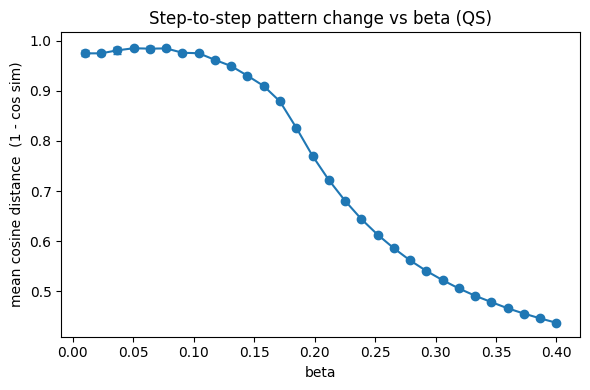

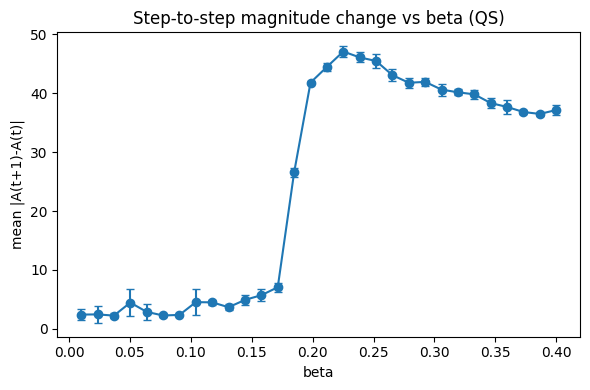

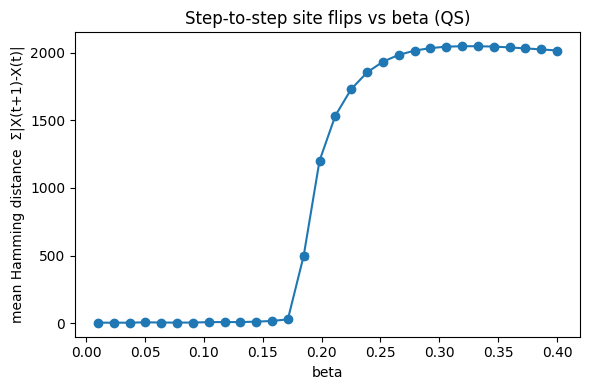

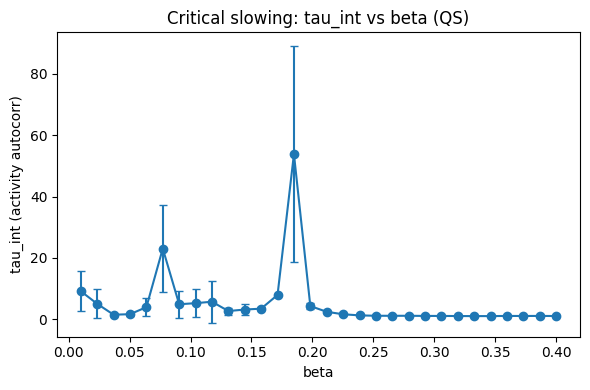

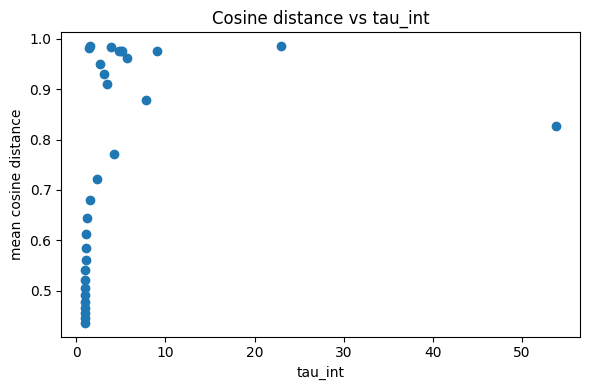

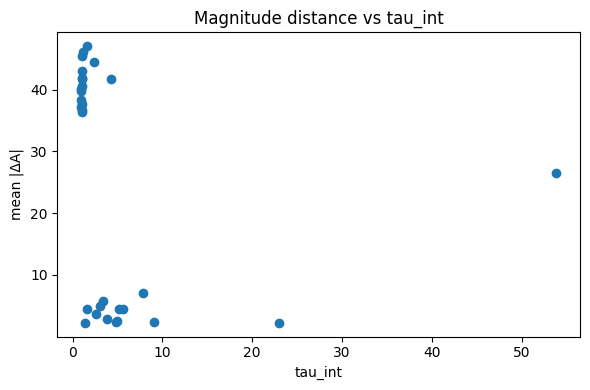

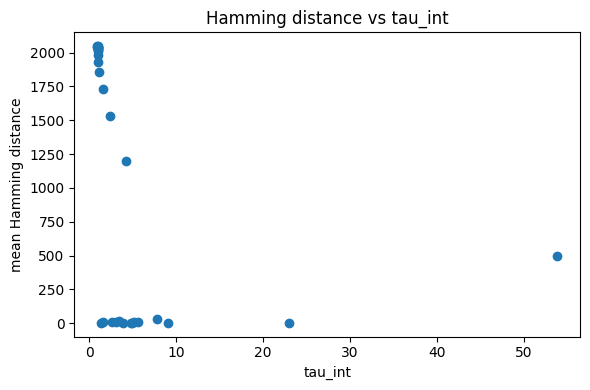

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# QS run that records:
#  - activity A(t)=sum X
#  - cosine distance between X(t) and X(t+1)   (pattern/orientation change)
#  - magnitude difference between A(t) and A(t+1) (scale change)
#  - Hamming / L1 distance sum|X(t)-X(t+1)|     (number of spin flips)
# and then tau_int from autocorr of A(t)
# ============================================================

def autocorr_fft(x):
    x = np.asarray(x, float)
    x = x - x.mean()
    n = len(x)
    if n < 2:
        return np.array([1.0])
    f = np.fft.rfft(x, n=2*n)
    ac = np.fft.irfft(f * np.conjugate(f))[:n]
    ac /= ac[0] if ac[0] != 0 else 1.0
    return ac

def tau_int_from_acf(acf, max_lag=800):
    L = min(max_lag, len(acf) - 1)
    neg = np.where(acf[1:L+1] < 0)[0]
    if neg.size:
        L = int(neg[0] + 1)
    return 1.0 + 2.0 * np.sum(acf[1:L+1])

def qs_metrics_series(
    L, beta, mu,
    T=20000, burn=2000,
    buffer_size=100,
    save_every=10,
    seed=0,
):
    """
    Quasi-stationary SIS:
      - resurrect from buffer if extinction occurs
      - record metrics every 'save_every' steps after burn-in
    Returns:
      A (N,), cosdist (N-1,), dA (N-1,), hamming (N-1,)
    """
    rng = np.random.default_rng(seed)
    X = (rng.random((L, L)) < 0.05).astype(np.int8)

    buffer = []
    A_list = []
    cos_list = []
    dA_list = []
    ham_list = []

    X_prev = None
    A_prev = None

    for t in range(T):
        # QS resurrection if extinct
        if X.sum() == 0:
            if buffer:
                X = buffer[rng.integers(0, len(buffer))].copy()
            else:
                X = (rng.random((L, L)) < 0.05).astype(np.int8)

        # store active configs occasionally
        if (t % 20 == 0) and (X.sum() > 0):
            if len(buffer) < buffer_size:
                buffer.append(X.copy())
            else:
                buffer[rng.integers(0, buffer_size)] = X.copy()

        # step SIS
        X = sis_step(X, beta, mu, rng)

        # record after burn-in
        if t >= burn and (t % save_every == 0):
            A = int(X.sum())
            A_list.append(A)

            if X_prev is not None:
                # Flatten only when needed (4096 elems for L=64; fine)
                x = X_prev.ravel().astype(np.float32)
                y = X.ravel().astype(np.float32)

                # cosine distance: 1 - (x·y)/(||x|| ||y||)
                # For binary x,y: x·y is overlap count; ||x|| = sqrt(A_prev), ||y|| = sqrt(A)
                dot = float(np.dot(x, y))
                nx = float(np.sqrt(A_prev))
                ny = float(np.sqrt(A))
                if nx > 0 and ny > 0:
                    cos_sim = dot / (nx * ny)
                    cos_dist = 1.0 - cos_sim
                else:
                    cos_dist = np.nan  # shouldn't happen in QS but keep safe

                # magnitude distance in activity (scale change)
                dA = abs(A - A_prev)

                # summed difference (Hamming / L1): how many sites changed state
                ham = float(np.sum(np.abs(y - x)))

                cos_list.append(cos_dist)
                dA_list.append(dA)
                ham_list.append(ham)

            X_prev = X.copy()
            A_prev = A

    A_arr = np.array(A_list, dtype=float)
    cos_arr = np.array(cos_list, dtype=float)
    dA_arr  = np.array(dA_list, dtype=float)
    ham_arr = np.array(ham_list, dtype=float)

    return A_arr, cos_arr, dA_arr, ham_arr

def sweep_beta_metrics(
    betas, L=64, mu=0.5,
    reps=3,
    T=20000, burn=2000, buffer_size=100, save_every=10,
    max_lag=800,
    seed0=0,
):
    betas = np.asarray(betas, float)

    out = {
        "beta": betas,
        "tau_int_mean": np.zeros_like(betas),
        "tau_int_std":  np.zeros_like(betas),
        "cos_mean":     np.zeros_like(betas),
        "cos_std":      np.zeros_like(betas),
        "dA_mean":      np.zeros_like(betas),
        "dA_std":       np.zeros_like(betas),
        "ham_mean":     np.zeros_like(betas),
        "ham_std":      np.zeros_like(betas),
    }

    for i, b in enumerate(betas):
        taus = []
        coss = []
        dAs  = []
        hams = []

        for r in range(reps):
            A, cosd, dA, ham = qs_metrics_series(
                L=L, beta=float(b), mu=float(mu),
                T=T, burn=burn, buffer_size=buffer_size, save_every=save_every,
                seed=seed0 + 10000*i + r
            )

            acf = autocorr_fft(A)
            tau = tau_int_from_acf(acf, max_lag=max_lag)

            # time-averaged step-to-step metrics
            taus.append(tau)
            coss.append(np.nanmean(cosd))
            dAs.append(np.nanmean(dA))
            hams.append(np.nanmean(ham))

        taus = np.array(taus, float)
        coss = np.array(coss, float)
        dAs  = np.array(dAs, float)
        hams = np.array(hams, float)

        out["tau_int_mean"][i] = taus.mean()
        out["tau_int_std"][i]  = taus.std(ddof=1) if reps > 1 else 0.0
        out["cos_mean"][i]     = coss.mean()
        out["cos_std"][i]      = coss.std(ddof=1) if reps > 1 else 0.0
        out["dA_mean"][i]      = dAs.mean()
        out["dA_std"][i]       = dAs.std(ddof=1) if reps > 1 else 0.0
        out["ham_mean"][i]     = hams.mean()
        out["ham_std"][i]      = hams.std(ddof=1) if reps > 1 else 0.0

        print(f"beta={b:.4f}  tau_int={out['tau_int_mean'][i]:.2f}  "
              f"cosDist={out['cos_mean'][i]:.4f}  dA={out['dA_mean'][i]:.2f}  ham={out['ham_mean'][i]:.1f}")

    return out


# =========================
# RUN (your settings)
# =========================
L = 64
mu = 0.5
betas = np.linspace(0.01, 0.4, 30)

# "Quick but smooth-ish" defaults:
#   reps=2 is fastest, reps=3 is nicer
#   T=15000 is faster, T=20000 is nicer
res = sweep_beta_metrics(
    betas, L=L, mu=mu,
    reps=3,
    T=20000, burn=2000, buffer_size=100, save_every=10,
    max_lag=800,
    seed0=123
)

b = res["beta"]
tau = res["tau_int_mean"]

# --- metrics vs beta ---
plt.figure(figsize=(6,4))
plt.errorbar(b, res["cos_mean"], yerr=res["cos_std"], marker="o", capsize=3)
plt.xlabel("beta"); plt.ylabel("mean cosine distance  (1 - cos sim)")
plt.title("Step-to-step pattern change vs beta (QS)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.errorbar(b, res["dA_mean"], yerr=res["dA_std"], marker="o", capsize=3)
plt.xlabel("beta"); plt.ylabel("mean |A(t+1)-A(t)|")
plt.title("Step-to-step magnitude change vs beta (QS)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.errorbar(b, res["ham_mean"], yerr=res["ham_std"], marker="o", capsize=3)
plt.xlabel("beta"); plt.ylabel("mean Hamming distance  Σ|X(t+1)-X(t)|")
plt.title("Step-to-step site flips vs beta (QS)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.errorbar(b, res["tau_int_mean"], yerr=res["tau_int_std"], marker="o", capsize=3)
plt.xlabel("beta"); plt.ylabel("tau_int (activity autocorr)")
plt.title("Critical slowing: tau_int vs beta (QS)")
plt.tight_layout(); plt.show()

# --- distances vs tau_int (your "versus tau") ---
plt.figure(figsize=(6,4))
plt.plot(tau, res["cos_mean"], marker="o", linestyle="none")
plt.xlabel("tau_int"); plt.ylabel("mean cosine distance")
plt.title("Cosine distance vs tau_int")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(tau, res["dA_mean"], marker="o", linestyle="none")
plt.xlabel("tau_int"); plt.ylabel("mean |ΔA|")
plt.title("Magnitude distance vs tau_int")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(tau, res["ham_mean"], marker="o", linestyle="none")
plt.xlabel("tau_int"); plt.ylabel("mean Hamming distance")
plt.title("Hamming distance vs tau_int")
plt.tight_layout(); plt.show()


In [8]:
import numpy as np

# --- correlation length (2nd-moment) for 2D SIS lattice (periodic) ---
# Uses:  xi = [1/(2 sin(pi/L))] * sqrt( S(0)/S(kmin) - 1 )
# where S(0)=Var(A) with A(t)=sum X, and S(kmin)=<|FFT(X)[kmin]|^2> averaged over kmin=(±1,0),(0,±1)

def xi_second_moment(L, A_series, Skmin_mean):
    varA = float(np.var(A_series, ddof=0))
    if varA <= 0 or Skmin_mean <= 0:
        return np.nan
    ratio = varA / Skmin_mean
    if ratio <= 1.0:
        return np.nan
    return (1.0 / (2.0 * np.sin(np.pi / L))) * np.sqrt(ratio - 1.0)

def qs_xi_series(L, beta, mu, T=20000, burn=2000, buffer_size=100, save_every=10, seed=0):
    rng = np.random.default_rng(seed)
    X = (rng.random((L, L)) < 0.05).astype(np.int8)

    buffer = []
    A_list = []
    Skmin_sum = 0.0
    n_samp = 0

    for t in range(T):
        # QS resurrection if extinct
        if X.sum() == 0:
            if buffer:
                X = buffer[rng.integers(0, len(buffer))].copy()
            else:
                X = (rng.random((L, L)) < 0.05).astype(np.int8)

        # store configs for QS
        if (t % 20 == 0) and (X.sum() > 0):
            if len(buffer) < buffer_size:
                buffer.append(X.copy())
            else:
                buffer[rng.integers(0, buffer_size)] = X.copy()

        # SIS step (you already have this function)
        X = sis_step(X, beta, mu, rng)

        # sample
        if t >= burn and (t % save_every == 0):
            A = int(X.sum())
            A_list.append(A)

            F = np.fft.fft2(X)  # unnormalised
            Skmin_sum += (
                (np.abs(F[1, 0])**2 + np.abs(F[-1, 0])**2 +
                 np.abs(F[0, 1])**2 + np.abs(F[0, -1])**2) / 4.0
            )
            n_samp += 1

    A_arr = np.asarray(A_list, float)
    Skmin_mean = float(Skmin_sum / max(n_samp, 1))
    xi = xi_second_moment(L, A_arr, Skmin_mean)
    return xi, A_arr  # return A_arr if you want (e.g., tau_int too)

def sweep_beta_xi(betas, L=64, mu=0.5, reps=3, T=20000, burn=2000, buffer_size=100, save_every=10, seed0=0):
    betas = np.asarray(betas, float)
    xi_mean = np.zeros_like(betas)
    xi_std  = np.zeros_like(betas)

    for i, b in enumerate(betas):
        xis = []
        for r in range(reps):
            xi, _ = qs_xi_series(
                L=L, beta=float(b), mu=float(mu),
                T=T, burn=burn, buffer_size=buffer_size, save_every=save_every,
                seed=seed0 + 10000*i + r
            )
            xis.append(xi)

        xis = np.asarray(xis, float)
        xi_mean[i] = np.nanmean(xis)
        xi_std[i]  = np.nanstd(xis, ddof=1) if reps > 1 else 0.0
        print(f"beta={b:.4f}  xi={xi_mean[i]:.3f} ± {xi_std[i]:.3f}")

    return {"beta": betas, "xi_mean": xi_mean, "xi_std": xi_std}

# ---- usage (plot however you like) ----
L=64; mu=0.5
betas = np.linspace(0.01, 0.4, 30)
res = sweep_beta_xi(betas, L=L, mu=mu, reps=3, T=20000, burn=2000, save_every=10, seed0=123)

beta=0.0100  xi=36.984 ± 8.576
beta=0.0234  xi=35.641 ± 18.805
beta=0.0369  xi=28.806 ± 7.263
beta=0.0503  xi=36.379 ± 8.573
beta=0.0638  xi=24.102 ± 11.808
beta=0.0772  xi=12.521 ± 2.245
beta=0.0907  xi=14.783 ± 9.187
beta=0.1041  xi=29.124 ± 0.588
beta=0.1176  xi=20.956 ± 2.791
beta=0.1310  xi=8.074 ± 4.449
beta=0.1445  xi=9.762 ± 6.670
beta=0.1579  xi=12.200 ± 2.667
beta=0.1714  xi=3.907 ± nan
beta=0.1848  xi=5.365 ± 1.922
beta=0.1983  xi=2.760 ± 0.729
beta=0.2117  xi=1.550 ± 0.491
beta=0.2252  xi=2.406 ± 1.012
beta=0.2386  xi=1.191 ± 0.579
beta=0.2521  xi=1.361 ± 1.077
beta=0.2655  xi=1.816 ± 0.467
beta=0.2790  xi=nan ± nan
beta=0.2924  xi=1.095 ± 0.385
beta=0.3059  xi=1.223 ± 0.534
beta=0.3193  xi=1.381 ± nan
beta=0.3328  xi=1.373 ± 1.374
beta=0.3462  xi=0.375 ± nan
beta=0.3597  xi=1.201 ± 0.645
beta=0.3731  xi=0.784 ± nan
beta=0.3866  xi=1.348 ± 0.289
beta=0.4000  xi=1.355 ± 0.790


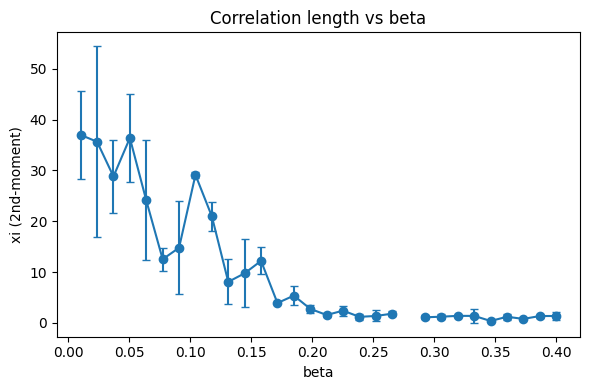

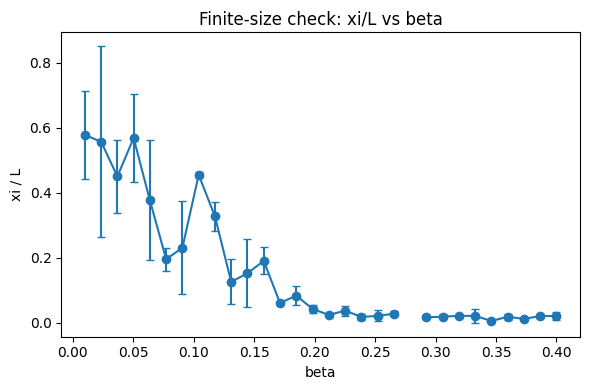

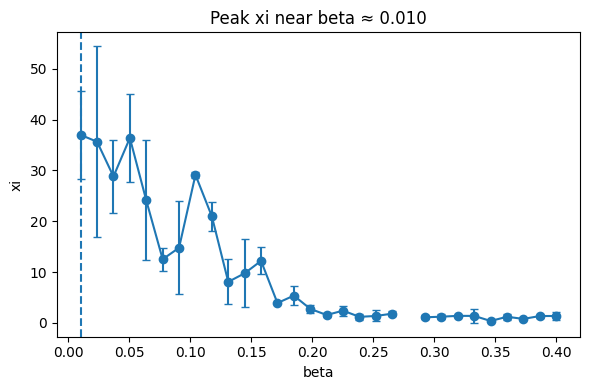

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# after your sweep:
b  = res["beta"]
xm = res["xi_mean"]
xs = res["xi_std"]

# 1) xi vs beta (with error bars)
plt.figure(figsize=(6,4))
plt.errorbar(b, xm, yerr=xs, marker="o", capsize=3)
plt.xlabel("beta"); plt.ylabel("xi (2nd-moment)")
plt.title("Correlation length vs beta")
plt.tight_layout(); plt.show()

# 2) xi/L vs beta (shows finite-size saturation)
plt.figure(figsize=(6,4))
plt.errorbar(b, xm/L, yerr=xs/L, marker="o", capsize=3)
plt.xlabel("beta"); plt.ylabel("xi / L")
plt.title("Finite-size check: xi/L vs beta")
plt.tight_layout(); plt.show()

# 3) highlight where xi is maximal (rough 'critical' region for this L)
imax = np.nanargmax(xm)
plt.figure(figsize=(6,4))
plt.errorbar(b, xm, yerr=xs, marker="o", capsize=3)
plt.axvline(b[imax], linestyle="--")
plt.xlabel("beta"); plt.ylabel("xi")
plt.title(f"Peak xi near beta ≈ {b[imax]:.3f}")
plt.tight_layout(); plt.show()


In [5]:
import numpy as np

def angular_velocity_deg(x0, x1):
    """Angle between x0 and x1 in degrees (cosine angle)."""
    n0 = np.linalg.norm(x0)
    n1 = np.linalg.norm(x1)
    if n0 == 0 or n1 == 0:
        return np.nan
    c = float(np.dot(x0, x1) / (n0 * n1))
    c = max(-1.0, min(1.0, c))
    return np.degrees(np.arccos(c))


In [6]:
import numpy as np

def make_directed_er(N, p_conn, rng):
    A = (rng.random((N, N)) < p_conn)
    np.fill_diagonal(A, False)
    return A

def run_branching_avalanche(N=2000, sigma=1.0, p_conn=0.01, Tmax=2000, seed=0):
    """
    Start from 1 active node. Each active node attempts to activate its outgoing neighbors.
    Choose per-edge activation probability so expected offspring ~ sigma.
    Returns:
      size_total (int), duration (int), mean_ang_vel (float)
    """
    rng = np.random.default_rng(seed)
    A = make_directed_er(N, p_conn, rng)

    # expected out-degree ~ p_conn*(N-1)
    out_deg = A.sum(axis=1).mean()
    p_act = min(1.0, sigma / max(out_deg, 1e-12))  # per-edge activation prob

    x = np.zeros(N, dtype=np.float32)
    x[rng.integers(0, N)] = 1.0

    size_total = 0
    angs = []
    t = 0

    while x.sum() > 0 and t < Tmax:
        size_total += int(x.sum())

        active = np.where(x > 0)[0]
        # count number of active parents per node
        parent_counts = A[active].sum(axis=0).astype(np.int32)

        # each susceptible node gets activated if any parent succeeds:
        # p = 1 - (1-p_act)^(#parents)
        p = 1.0 - (1.0 - p_act) ** parent_counts
        x_next = (rng.random(N) < p).astype(np.float32)

        angs.append(angular_velocity_deg(x, x_next))
        x = x_next
        t += 1

    duration = t
    mean_ang = np.nanmean(angs) if len(angs) else np.nan
    return size_total, duration, mean_ang

def sweep_sigma(sigmas=np.linspace(0.6, 1.4, 9), reps=50):
    out = []
    for sigma in sigmas:
        sizes, durs, angs = [], [], []
        for r in range(reps):
            S, T, ang = run_branching_avalanche(sigma=sigma, seed=r)
            sizes.append(S); durs.append(T); angs.append(ang)
        out.append((sigma, np.mean(sizes), np.mean(durs), np.nanmean(angs)))
        print(f"sigma={sigma:.2f}  mean_size={np.mean(sizes):.1f}  mean_dur={np.mean(durs):.1f}  mean_ang={np.nanmean(angs):.2f}°")
    return out

# Example:
# sweep_sigma()


[branching] sigma=0.600  mean_size=    3.80  mean_dur=   2.60  mean_ang= 90.00°
[branching] sigma=0.656  mean_size=    3.90  mean_dur=   2.70  mean_ang= 90.00°
[branching] sigma=0.711  mean_size=    4.50  mean_dur=   2.73  mean_ang= 90.00°
[branching] sigma=0.767  mean_size=    5.40  mean_dur=   3.20  mean_ang= 90.00°
[branching] sigma=0.822  mean_size=    9.30  mean_dur=   4.00  mean_ang= 90.00°
[branching] sigma=0.878  mean_size=   10.60  mean_dur=   4.17  mean_ang= 90.00°
[branching] sigma=0.933  mean_size=   21.73  mean_dur=   6.50  mean_ang= 89.98°
[branching] sigma=0.989  mean_size=   53.53  mean_dur=   9.83  mean_ang= 89.94°
[branching] sigma=1.044  mean_size=32369.90  mean_dur= 214.70  mean_ang= 89.64°
[branching] sigma=1.100  mean_size=403550.37  mean_dur=1171.27  mean_ang= 87.20°


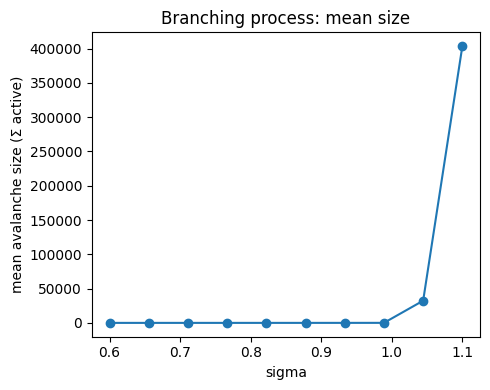

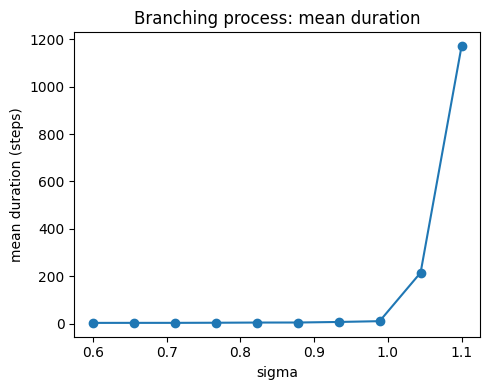

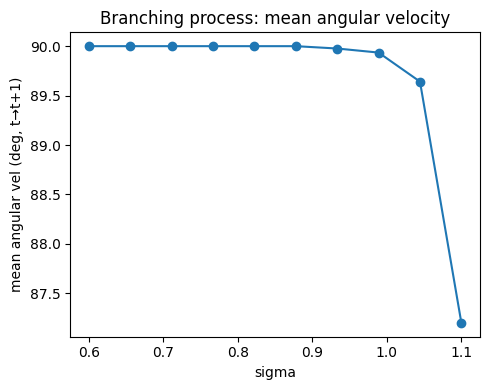

[SIS]      beta=0.020  mean_size=    2.30  mean_dur=   2.27  mean_ang=  2.40°
[SIS]      beta=0.051  mean_size=    3.00  mean_dur=   2.73  mean_ang= 19.78°
[SIS]      beta=0.082  mean_size=    4.40  mean_dur=   3.57  mean_ang= 22.98°
[SIS]      beta=0.113  mean_size=    6.40  mean_dur=   4.33  mean_ang= 29.13°
[SIS]      beta=0.144  mean_size=   28.87  mean_dur=   9.53  mean_ang= 42.76°
[SIS]      beta=0.176  mean_size=  244.40  mean_dur=  28.20  mean_ang= 49.02°
[SIS]      beta=0.207  mean_size=7665111.87  mean_dur=8003.23  mean_ang= 51.96°
[SIS]      beta=0.238  mean_size=16111793.93  mean_dur=11335.43  mean_ang= 54.98°
[SIS]      beta=0.269  mean_size=25123013.60  mean_dur=14667.70  mean_ang= 53.89°


KeyboardInterrupt: 

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Helpers
# -------------------------
def angular_velocity_deg(x0, x1):
    """Angle between x0 and x1 in degrees (cosine angle). x0,x1 are 0/1 float arrays."""
    n0 = np.linalg.norm(x0)
    n1 = np.linalg.norm(x1)
    if n0 == 0.0 or n1 == 0.0:
        return np.nan
    c = float(np.dot(x0, x1) / (n0 * n1))
    c = max(-1.0, min(1.0, c))
    return np.degrees(np.arccos(c))

# -------------------------
# 1) Branching process (sparse directed random graph)
# -------------------------
def make_sparse_directed_graph(N, mean_out_degree, rng):
    """Adjacency lists; each node has Poisson(mean_out_degree) outgoing edges."""
    outs = []
    for u in range(N):
        k = rng.poisson(mean_out_degree)
        if k <= 0:
            outs.append(np.empty(0, dtype=np.int32))
            continue
        nbrs = rng.integers(0, N, size=k, dtype=np.int32)
        nbrs = nbrs[nbrs != u]  # drop self-loops
        outs.append(nbrs)
    return outs

def run_branching_avalanche(N=2000, sigma=1.0, mean_out_degree=20, Tmax=5000, seed=0):
    """
    Start from 1 active node; propagate along outgoing edges.
    Choose per-edge activation prob so expected offspring per active node ~ sigma.

    Returns: size_total, duration, mean_ang
      size_total = sum_t (#active_t)
      duration   = steps until extinction
      mean_ang   = mean angular velocity between x_t and x_{t+1}
    """
    rng = np.random.default_rng(seed)
    outs = make_sparse_directed_graph(N, mean_out_degree, rng)
    out_deg_mean = np.mean([len(v) for v in outs]) if N else 0.0
    p_act = min(1.0, sigma / max(out_deg_mean, 1e-12))

    x = np.zeros(N, dtype=np.float32)
    x[rng.integers(0, N)] = 1.0  # seed

    size_total, angs, t = 0, [], 0
    while x.sum() > 0 and t < Tmax:
        size_total += int(x.sum())
        active_idx = np.flatnonzero(x > 0)

        x_next = np.zeros(N, dtype=np.float32)
        for u in active_idx:
            nbrs = outs[u]
            if nbrs.size == 0:
                continue
            hits = nbrs[rng.random(nbrs.size) < p_act]
            if hits.size:
                x_next[hits] = 1.0

        angs.append(angular_velocity_deg(x, x_next))
        x = x_next
        t += 1

    return size_total, t, (np.nanmean(angs) if angs else np.nan)

def sweep_branching(sigmas, reps=25, **kwargs):
    rows = []
    for s in sigmas:
        Ss, Ts, As = [], [], []
        for r in range(reps):
            S, T, A = run_branching_avalanche(sigma=s, seed=r, **kwargs)
            Ss.append(S); Ts.append(T); As.append(A)
        rows.append((s, np.mean(Ss), np.mean(Ts), np.nanmean(As)))
        print(f"[branching] sigma={s:.3f}  mean_size={np.mean(Ss):8.2f}  mean_dur={np.mean(Ts):7.2f}  mean_ang={np.nanmean(As):6.2f}°")
    return np.array(rows, dtype=float)

# -------------------------
# 2) SIS on 2D periodic lattice (discrete-time synchronous)
# -------------------------
def sis_step(grid, beta, mu, rng):
    """
    One synchronous SIS update on a 2D periodic lattice.
    - infected recover with prob mu
    - susceptible infected with prob 1-(1-beta)^k where k is # infected 4-neighbors
    """
    k = (
        np.roll(grid,  1, axis=0) + np.roll(grid, -1, axis=0) +
        np.roll(grid,  1, axis=1) + np.roll(grid, -1, axis=1)
    )

    infected = (grid == 1)
    susceptible = ~infected

    recov = (rng.random(grid.shape) < mu) & infected

    p_inf = 1.0 - (1.0 - beta) ** k
    new_inf = (rng.random(grid.shape) < p_inf) & susceptible

    nxt = grid.copy()
    nxt[recov] = 0
    nxt[new_inf] = 1
    return nxt

def run_sis_avalanche(L=64, beta=0.12, mu=0.50, Tmax=20000, seed=0):
    """
    Start from 1 infected, run until extinction.
    Returns: size_total, duration, mean_ang
      size_total = sum_t (#infected_t)
      duration   = steps until extinction
      mean_ang   = mean angular velocity between flattened grids
    """
    rng = np.random.default_rng(seed)
    grid = np.zeros((L, L), dtype=np.int8)
    grid[rng.integers(0, L), rng.integers(0, L)] = 1

    x = grid.reshape(-1).astype(np.float32)
    size_total, angs, t = 0, [], 0

    while grid.sum() > 0 and t < Tmax:
        size_total += int(grid.sum())
        grid_next = sis_step(grid, beta, mu, rng)
        x_next = grid_next.reshape(-1).astype(np.float32)

        angs.append(angular_velocity_deg(x, x_next))
        grid = grid_next
        x = x_next
        t += 1

    return size_total, t, (np.nanmean(angs) if angs else np.nan)

def sweep_sis(betas, reps=25, **kwargs):
    rows = []
    for b in betas:
        Ss, Ts, As = [], [], []
        for r in range(reps):
            S, T, A = run_sis_avalanche(beta=b, seed=r, **kwargs)
            Ss.append(S); Ts.append(T); As.append(A)
        rows.append((b, np.mean(Ss), np.mean(Ts), np.nanmean(As)))
        print(f"[SIS]      beta={b:.3f}  mean_size={np.mean(Ss):8.2f}  mean_dur={np.mean(Ts):7.2f}  mean_ang={np.nanmean(As):6.2f}°")
    return np.array(rows, dtype=float)

# -------------------------
# Plotting
# -------------------------
def plot_rows(rows, xname, title_prefix):
    x = rows[:, 0]
    mean_size = rows[:, 1]
    mean_dur  = rows[:, 2]
    mean_ang  = rows[:, 3]

    plt.figure(figsize=(5,4))
    plt.plot(x, mean_size, marker="o")
    plt.xlabel(xname); plt.ylabel("mean avalanche size (Σ active)")
    plt.title(f"{title_prefix}: mean size")
    plt.tight_layout()

    plt.figure(figsize=(5,4))
    plt.plot(x, mean_dur, marker="o")
    plt.xlabel(xname); plt.ylabel("mean duration (steps)")
    plt.title(f"{title_prefix}: mean duration")
    plt.tight_layout()

    plt.figure(figsize=(5,4))
    plt.plot(x, mean_ang, marker="o")
    plt.xlabel(xname); plt.ylabel("mean angular vel (deg, t→t+1)")
    plt.title(f"{title_prefix}: mean angular velocity")
    plt.tight_layout()

    plt.show()

# -------------------------
# RUN
# -------------------------
# Branching sweep (critical near sigma ~ 1)
sigmas = np.linspace(0.6, 1.1, 10)
br_rows = sweep_branching(sigmas, reps=30, N=2000, mean_out_degree=20, Tmax=5000)
plot_rows(br_rows, "sigma", "Branching process")

# SIS sweep (threshold depends on mu, lattice size)
betas = np.linspace(0.02, 0.30, 10)
sis_rows = sweep_sis(betas, reps=30, L=64, mu=0.50, Tmax=20000)
plot_rows(sis_rows, "beta", "SIS on 2D lattice")


[wolff] L= 32  T=1.700  chi=594376862.59  U4=0.667  <|m|>=0.970
[wolff] L= 32  T=1.800  chi=545901479.87  U4=0.666  <|m|>=0.957
[wolff] L= 32  T=1.900  chi=497361545.32  U4=0.666  <|m|>=0.938
[wolff] L= 32  T=2.000  chi=446297105.89  U4=0.665  <|m|>=0.911
[wolff] L= 32  T=2.100  chi=389206687.31  U4=0.664  <|m|>=0.871
[wolff] L= 32  T=2.200  chi=305794298.09  U4=0.652  <|m|>=0.786
[wolff] L= 32  T=2.300  chi=180681774.99  U4=0.582  <|m|>=0.591
[wolff] L= 32  T=2.400  chi=55957520.41  U4=0.339  <|m|>=0.303
[wolff] L= 32  T=2.500  chi=28686686.12  U4=0.197  <|m|>=0.214
[wolff] L= 32  T=2.600  chi=13510886.16  U4=0.044  <|m|>=0.145
[wolff] L= 32  T=2.700  chi=8669713.56  U4=-0.018  <|m|>=0.118
[wolff] L= 32  T=2.800  chi=5787336.68  U4=0.052  <|m|>=0.099
[wolff] L= 32  T=2.900  chi=4871781.33  U4=0.051  <|m|>=0.092
[wolff] L= 32  T=3.000  chi=3445912.81  U4=0.038  <|m|>=0.079
[wolff] L= 32  T=3.100  chi=3113586.25  U4=0.038  <|m|>=0.076
[wolff] L= 32  T=3.200  chi=2612584.76  U4=-0.169  <

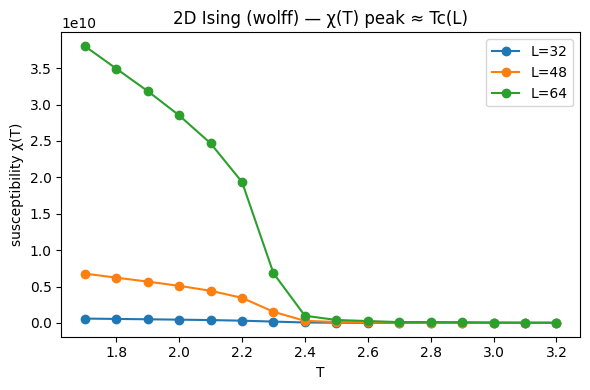

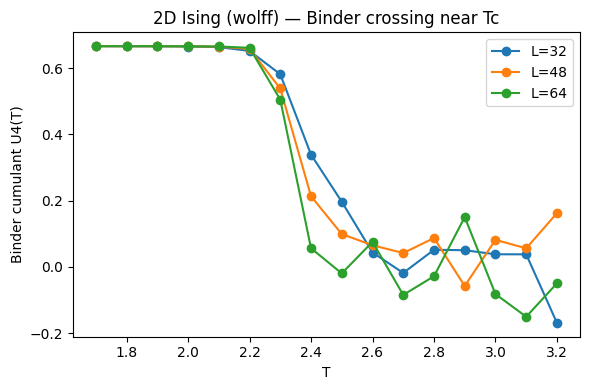

Approx Tc proxy (chi peak) for L=64: T≈1.700  (true infinite-L Tc≈2.269)


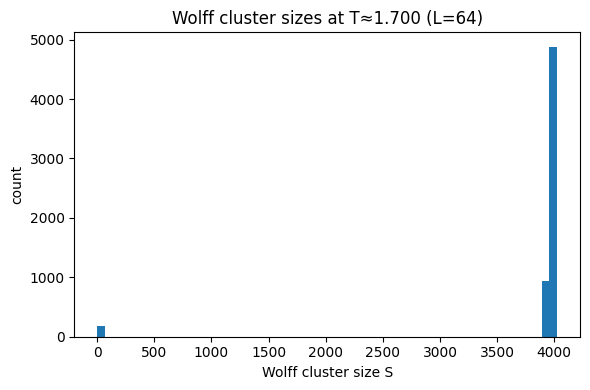

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Ising helpers
# -------------------------
def init_spins(L, rng):
    return rng.choice([-1, 1], size=(L, L)).astype(np.int8)

def magnetization(spins):
    return int(spins.sum())

# -------------------------
# Metropolis dynamics
# -------------------------
def sweep_metropolis(spins, beta, rng):
    """One sweep = L*L attempted single-spin flips (periodic BC)."""
    L = spins.shape[0]
    for _ in range(L * L):
        i = rng.integers(0, L)
        j = rng.integers(0, L)
        s = spins[i, j]
        nn = (
            spins[(i-1) % L, j] + spins[(i+1) % L, j] +
            spins[i, (j-1) % L] + spins[i, (j+1) % L]
        )
        dE = 2 * s * nn  # J=1
        if dE <= 0 or rng.random() < np.exp(-beta * dE):
            spins[i, j] = -s

# -------------------------
# Wolff dynamics
# -------------------------
def wolff_step(spins, beta, rng):
    """
    One Wolff cluster flip. Returns cluster size.
    Uses p_add = 1 - exp(-2*beta*J) with J=1.
    """
    L = spins.shape[0]
    p_add = 1.0 - np.exp(-2.0 * beta)

    i0 = rng.integers(0, L)
    j0 = rng.integers(0, L)
    s0 = spins[i0, j0]

    in_cluster = np.zeros((L, L), dtype=bool)
    stack = [(i0, j0)]
    in_cluster[i0, j0] = True
    cluster = [(i0, j0)]

    while stack:
        i, j = stack.pop()
        for ni, nj in [((i-1) % L, j), ((i+1) % L, j), (i, (j-1) % L), (i, (j+1) % L)]:
            if (not in_cluster[ni, nj]) and spins[ni, nj] == s0:
                if rng.random() < p_add:
                    in_cluster[ni, nj] = True
                    stack.append((ni, nj))
                    cluster.append((ni, nj))

    # flip cluster
    for (i, j) in cluster:
        spins[i, j] = -spins[i, j]

    return len(cluster)

# -------------------------
# Observable estimation per temperature
# -------------------------
def run_ising(L=64, T=2.3, algo="wolff", n_therm=200, n_steps=2000, seed=0, record_clusters=False):
    """
    Returns dict with:
      chi  : susceptibility (finite-size)
      U4   : Binder cumulant
      mabs : mean |m|
      Ms   : raw magnetizations (optional for your analysis)
      Ss   : Wolff cluster sizes (if record_clusters=True and algo='wolff')
    """
    rng = np.random.default_rng(seed)
    beta = 1.0 / T
    spins = init_spins(L, rng)
    N = L * L

    # thermalize
    if algo == "metropolis":
        for _ in range(n_therm):
            sweep_metropolis(spins, beta, rng)
    elif algo == "wolff":
        for _ in range(n_therm):
            wolff_step(spins, beta, rng)
    else:
        raise ValueError("algo must be 'metropolis' or 'wolff'")

    Ms = np.empty(n_steps, dtype=np.float64)
    Ss = np.empty(n_steps, dtype=np.int32) if (record_clusters and algo == "wolff") else None

    for t in range(n_steps):
        if algo == "metropolis":
            sweep_metropolis(spins, beta, rng)
        else:
            s = wolff_step(spins, beta, rng)
            if Ss is not None:
                Ss[t] = s

        Ms[t] = magnetization(spins)

    # Observables
    Mmean = Ms.mean()
    M2 = np.mean(Ms**2)
    M4 = np.mean(Ms**4)

    chi = (N * (M2 - Mmean**2)) / T
    U4  = 1.0 - (M4 / (3.0 * (M2**2 + 1e-12)))
    mabs = np.mean(np.abs(Ms)) / N

    out = {"chi": chi, "U4": U4, "mabs": mabs, "Ms": Ms}
    if Ss is not None:
        out["Ss"] = Ss
    return out

def sweep_T(Ls=(32, 48, 64), Ts=np.linspace(1.7, 3.2, 16), algo="wolff",
            n_therm=300, n_steps=3000, seed=0):
    """
    Returns dict: results[L] = dict with arrays for T, chi, U4, mabs.
    """
    results = {}
    for L in Ls:
        chi_list, U4_list, mabs_list = [], [], []
        for i, T in enumerate(Ts):
            r = run_ising(L=L, T=float(T), algo=algo, n_therm=n_therm, n_steps=n_steps, seed=seed + 1000*L + i)
            chi_list.append(r["chi"])
            U4_list.append(r["U4"])
            mabs_list.append(r["mabs"])
            print(f"[{algo}] L={L:3d}  T={T:.3f}  chi={r['chi']:.2f}  U4={r['U4']:.3f}  <|m|>={r['mabs']:.3f}")
        results[L] = {
            "T": np.array(Ts, dtype=float),
            "chi": np.array(chi_list, dtype=float),
            "U4": np.array(U4_list, dtype=float),
            "mabs": np.array(mabs_list, dtype=float),
        }
    return results

# -------------------------
# RUN + PLOT
# -------------------------
Ts = np.linspace(1.7, 3.2, 16)

# Choose one:
algo = "wolff"        # fast near Tc (recommended)
# algo = "metropolis" # slower near Tc, but "local" dynamics

results = sweep_T(Ls=(32, 48, 64), Ts=Ts, algo=algo, n_therm=300, n_steps=2500, seed=1)

# Plot susceptibility
plt.figure(figsize=(6,4))
for L, r in results.items():
    plt.plot(r["T"], r["chi"], marker="o", label=f"L={L}")
plt.xlabel("T")
plt.ylabel("susceptibility χ(T)")
plt.title(f"2D Ising ({algo}) — χ(T) peak ≈ Tc(L)")
plt.legend()
plt.tight_layout()
plt.show()

# Plot Binder cumulant (curves cross near Tc)
plt.figure(figsize=(6,4))
for L, r in results.items():
    plt.plot(r["T"], r["U4"], marker="o", label=f"L={L}")
plt.xlabel("T")
plt.ylabel("Binder cumulant U4(T)")
plt.title(f"2D Ising ({algo}) — Binder crossing near Tc")
plt.legend()
plt.tight_layout()
plt.show()

# Optional: record Wolff cluster sizes at the Tc proxy for one L
if algo == "wolff":
    L0 = 64
    r0 = results[L0]
    Tc_proxy = r0["T"][np.argmax(r0["chi"])]
    print(f"Approx Tc proxy (chi peak) for L={L0}: T≈{Tc_proxy:.3f}  (true infinite-L Tc≈2.269)")

    rec = run_ising(L=L0, T=float(Tc_proxy), algo="wolff", n_therm=400, n_steps=6000, seed=999, record_clusters=True)
    Ss = rec["Ss"]

    plt.figure(figsize=(6,4))
    plt.hist(Ss, bins=60)
    plt.xlabel("Wolff cluster size S")
    plt.ylabel("count")
    plt.title(f"Wolff cluster sizes at T≈{Tc_proxy:.3f} (L={L0})")
    plt.tight_layout()
    plt.show()

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def init_spins(L, rng):
    return rng.choice([-1, 1], size=(L, L)).astype(np.int8)

def sweep_metropolis(spins, beta, rng):
    L = spins.shape[0]
    for _ in range(L*L):
        i = rng.integers(0, L); j = rng.integers(0, L)
        s = spins[i, j]
        nn = (spins[(i-1)%L, j] + spins[(i+1)%L, j] +
              spins[i, (j-1)%L] + spins[i, (j+1)%L])
        dE = 2 * s * nn  # J=1
        if dE <= 0 or rng.random() < np.exp(-beta * dE):
            spins[i, j] = -s

def run_ising_metropolis_with_velocity(L=64, T=2.3, n_therm=500, n_steps=3000, seed=0):
    """
    Samples every *sweep*.
    Returns:
      chi_per_spin, U4, mabs, q1_mean, ang_mean_deg
    """
    rng = np.random.default_rng(seed)
    beta = 1.0 / T
    spins = init_spins(L, rng)
    N = L*L

    # thermalize
    for _ in range(n_therm):
        sweep_metropolis(spins, beta, rng)

    Ms = np.empty(n_steps, dtype=np.float64)
    q1 = np.empty(n_steps-1, dtype=np.float64)

    prev = spins.reshape(-1).astype(np.int16).copy()

    for t in range(n_steps):
        sweep_metropolis(spins, beta, rng)
        cur = spins.reshape(-1).astype(np.int16)

        Ms[t] = cur.sum()

        if t > 0:
            # overlap q1 = (1/N) * sum_i s_i(t-1) s_i(t)
            q1[t-1] = (prev @ cur) / N

        prev = cur.copy()

    # thermodynamic observables
    Mmean = Ms.mean()
    M2 = np.mean(Ms**2)
    M4 = np.mean(Ms**4)

    # susceptibility per spin (sane scale)
    chi = (M2 - Mmean**2) / (N * T)

    # Binder cumulant
    U4 = 1.0 - (M4 / (3.0 * (M2**2 + 1e-12)))

    # magnetization magnitude per spin
    mabs = np.mean(np.abs(Ms)) / N

    # angular velocity derived from overlap
    q1_mean = float(np.mean(q1))
    ang_mean = float(np.degrees(np.arccos(np.clip(q1_mean, -1.0, 1.0))))

    return chi, U4, mabs, q1_mean, ang_mean

def sweep_T(L=64, Ts=np.linspace(1.7, 3.2, 16), n_therm=500, n_steps=3000, seed=0):
    out = {"T": [], "chi": [], "U4": [], "mabs": [], "q1": [], "ang": []}
    for i, T in enumerate(Ts):
        chi, U4, mabs, q1, ang = run_ising_metropolis_with_velocity(
            L=L, T=float(T), n_therm=n_therm, n_steps=n_steps, seed=seed+i
        )
        out["T"].append(T); out["chi"].append(chi); out["U4"].append(U4)
        out["mabs"].append(mabs); out["q1"].append(q1); out["ang"].append(ang)
        print(f"T={T:.3f}  chi={chi:.4f}  U4={U4:.3f}  <|m|>={mabs:.3f}  <q1>={q1:.4f}  <ang>={ang:.2f}°")
    for k in out:
        out[k] = np.array(out[k], dtype=float)
    return out

# ---- RUN ----
Ts = np.linspace(1.7, 3.2, 16)
data = sweep_T(L=64, Ts=Ts, n_therm=600, n_steps=4000, seed=1)

# Tc proxy (chi peak)
Tc_proxy = data["T"][np.argmax(data["chi"])]
print("\nTc proxy (chi peak):", Tc_proxy, "  (true infinite-L Tc≈2.269)")

# ---- PLOTS ----
plt.figure(figsize=(6,4))
plt.plot(data["T"], data["chi"], marker="o")
plt.axvline(Tc_proxy, linestyle="--")
plt.xlabel("T"); plt.ylabel("susceptibility χ (per spin)")
plt.title("Ising Metropolis: χ(T)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(data["T"], data["U4"], marker="o")
plt.axvline(Tc_proxy, linestyle="--")
plt.xlabel("T"); plt.ylabel("Binder cumulant U4")
plt.title("Ising Metropolis: U4(T)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(data["T"], data["q1"], marker="o", label="overlap <q1>")
plt.axvline(Tc_proxy, linestyle="--")
plt.xlabel("T"); plt.ylabel("<q1> = (1/N) Σ s(t)s(t+1)")
plt.title("State persistence vs T (Metropolis sweeps)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(data["T"], data["ang"], marker="o", label="mean angle")
plt.axvline(Tc_proxy, linestyle="--")
plt.xlabel("T"); plt.ylabel("mean angular change (deg)")
plt.title("Angular velocity proxy vs T (Metropolis sweeps)")
plt.tight_layout(); plt.show()


T=1.700  chi=0.0689  U4=0.667  <|m|>=0.970  <q1>=0.9641  <ang>=15.40°
T=1.800  chi=28.9840  U4=0.469  <|m|>=0.224  <q1>=0.9141  <ang>=23.92°
T=1.900  chi=0.5755  U4=0.666  <|m|>=0.936  <q1>=0.9305  <ang>=21.49°
T=2.000  chi=6.2605  U4=0.663  <|m|>=0.895  <q1>=0.9043  <ang>=25.27°
T=2.100  chi=6.2323  U4=0.662  <|m|>=0.853  <q1>=0.8711  <ang>=29.42°
T=2.200  chi=25.0801  U4=0.645  <|m|>=0.743  <q1>=0.8227  <ang>=34.65°
T=2.300  chi=29.6118  U4=0.593  <|m|>=0.500  <q1>=0.7532  <ang>=41.13°
T=2.400  chi=95.0396  U4=0.307  <|m|>=0.205  <q1>=0.6890  <ang>=46.45°
T=2.500  chi=16.0060  U4=0.120  <|m|>=0.102  <q1>=0.6440  <ang>=49.91°
T=2.600  chi=9.8881  U4=0.045  <|m|>=0.066  <q1>=0.6077  <ang>=52.58°
T=2.700  chi=8.2193  U4=0.045  <|m|>=0.059  <q1>=0.5766  <ang>=54.79°


KeyboardInterrupt: 